In [1]:
#Read in the necessary libraries
import pandas as pd
import numpy as np
import itertools

#Matplotlib section
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns

#SKLearn and Scipy Models
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

#Import for the creation and visualization of decision trees
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
#from sklearn.externals.six import StringIO
from six import StringIO
from IPython.display import Image  
import pydotplus
from sklearn.metrics import make_scorer

#Import for random forest modeling
from sklearn.ensemble import RandomForestClassifier

In [2]:
import xgboost as xgb

#This code prevents the kernel from stopping when XGBoost is running
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

In [3]:
#Run this cell to hide warnings about package updates
import warnings
warnings.filterwarnings('ignore')

In [4]:
#I import pickle to save certain models
import pickle

In [5]:
#A function that takes in a model and a string with the model name and saves it to the repository
def make_pickle(model, model_name):
    model_pickle_path = 'Classification_Models_After_'+ model_name + '.pkl'
    # Create a variable to pickle and open it in write mode
    model_pickle = open(model_pickle_path, 'wb')
    pickle.dump(model, model_pickle)
    model_pickle.close()

In [6]:
#Read in the csv file containing the datafreame
election_df = pd.read_csv('updated_data/congressional_data_and_targets.csv')

## 1. Create the Boolean Target Variable

The data cleansing process was completed in the notebook titled "Census_Data_API_Work.ipynb"

In [7]:
#Creates a boolean column based on whether the district voted more for the Republican party or not (i.e. Democratic party/ Independent candidate)
election_df['Target_Presidential_R_bool'] = (election_df['Target_Presidential_R'] > election_df['Target_Presidential_D']).astype(int)


In [8]:
election_df.shape

(804, 54)

In [9]:
#Reorganize the dataframe so the target variable is on the right side and the identification cells are on the left
election_df = election_df[['CD_Id_Year', 'District_Name', 'State', 'Total_Pop', 'Total_Males', 'Total_Females', 'Median_Age', 'Total_Children', 'Total_White_People', 'Total_Afr_Am_People', 'Total_American_Ind_Alk_Ntv', 'Total_Asian', 'Total_Mexican_Origin', 'Total_Puerto_Rican_Origin', 'Total_Cuban_Origin', 'Total_Dominican_Origin', 'Total_Native_US', 'Total_Non_Citizens', 'Total_Foreign_Born', 'Median_Income', 'Median_Household_Income', 'Below_Poverty_Level_LTM', 'Total_Wealthy_Households', 'Gini_Index', 'Total_Less_Highschool', 'Total_Bachelor_Holders', 'Total_STEM', 'Total_Business_Degree', 'Total_Married_Households', 'Total_Veterans', 'Total_Labor_Force_Eligible', 'Total_Employed', 'Total_Unemployed', 'Median_Age_Of_Worker', 'Total_Workers', 'Total_Working_Agricult', 'Total_Working_Construction', 'Total_Working_Manufacturing', 'Total_Working_Retail', 'Total_Working_Transportation', 'Total_Working_Information', 'Total_Working_Finance', 'Total_Working_Education', 'Total_Working_Health', 'Total_Working_Food', 'Total_Working_Public_Admin', 'Median_Gross_Rent', 'Previous_Presidential_D', 'Previous_Presidential_R', 'Target_Presidential_R_bool']]

## 2. EDA

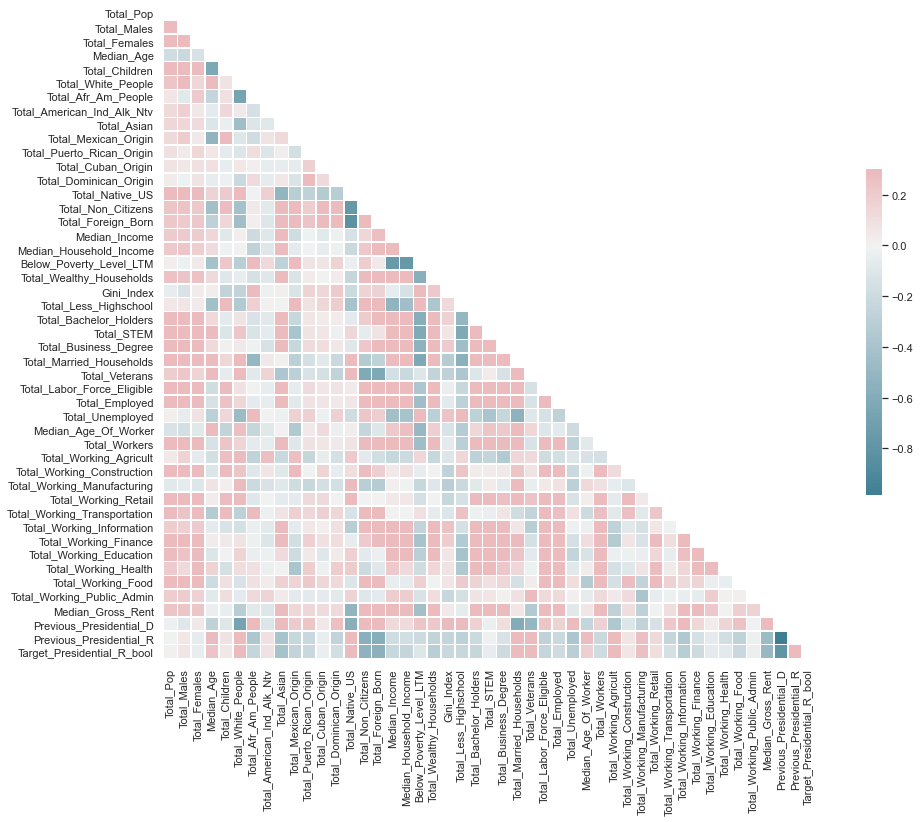

In [10]:
#This cell creates a correlation matrix to view the correlation between continuous features
#and the target variable
sns.set(style="white")

# Compute the correlation matrix
corr = election_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

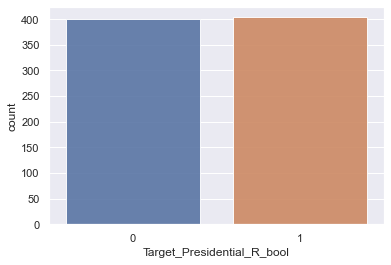

In [11]:
#A histogram of the target variable
sns.set_style('darkgrid')
sns.countplot(election_df['Target_Presidential_R_bool'], alpha=0.9)
#There is a negligible imbalance

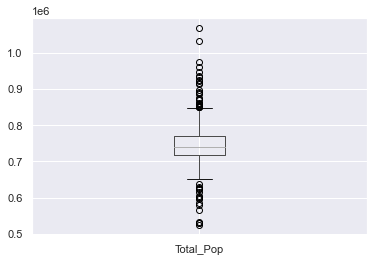

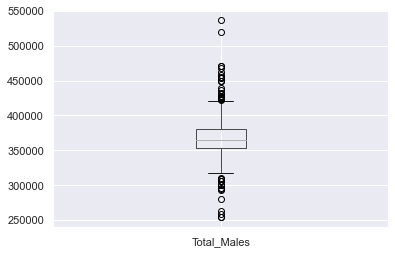

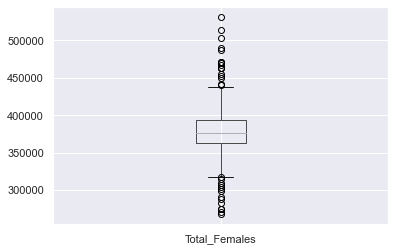

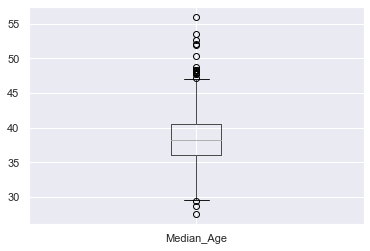

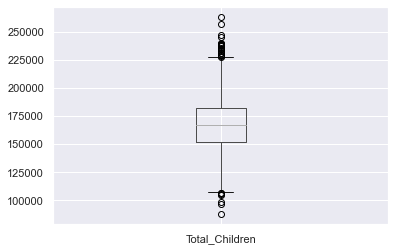

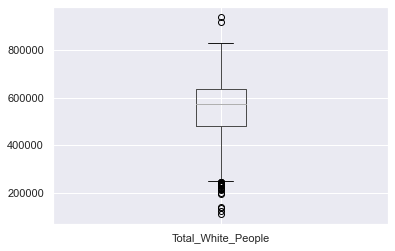

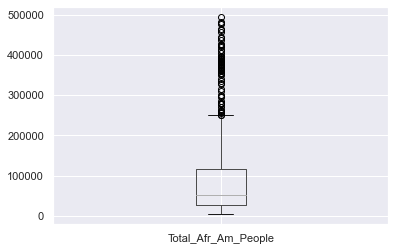

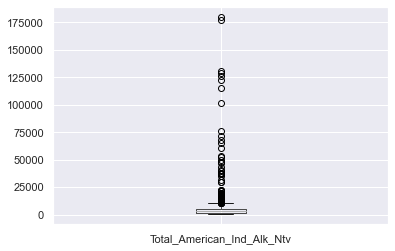

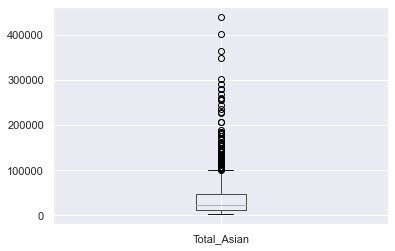

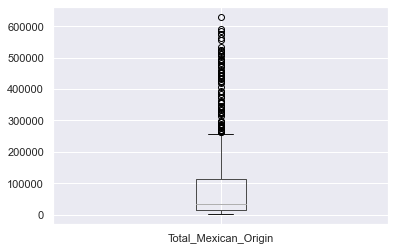

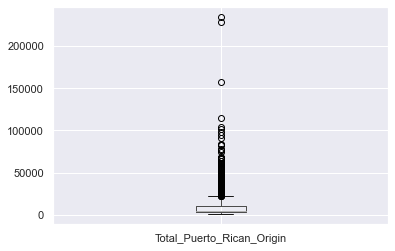

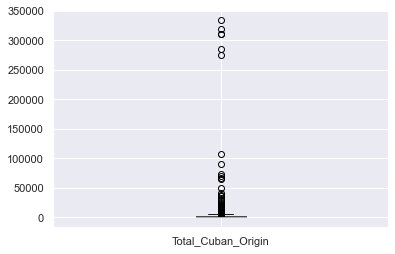

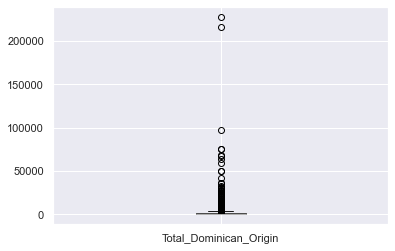

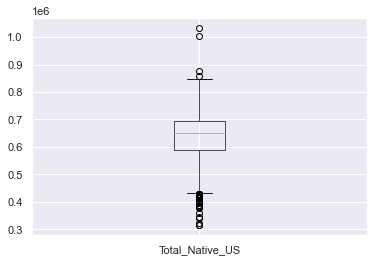

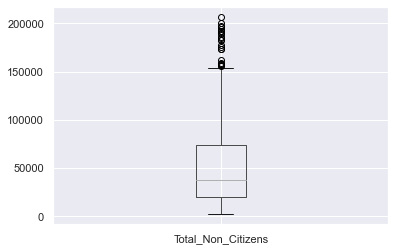

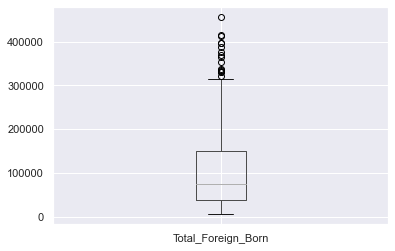

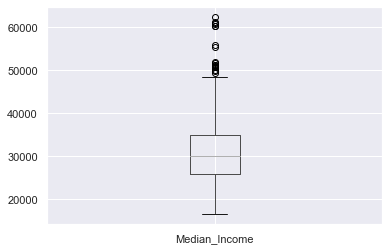

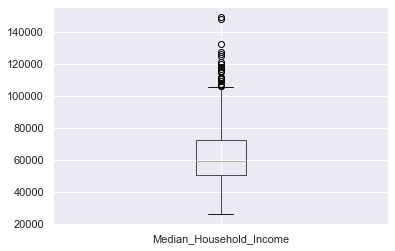

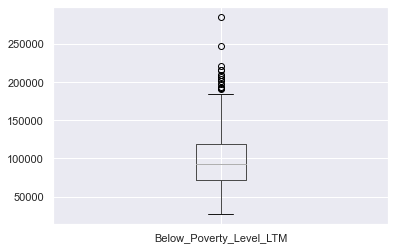

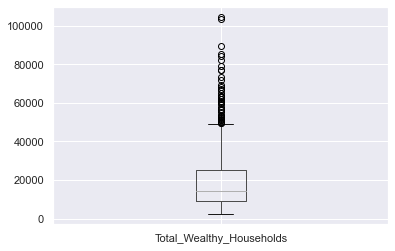

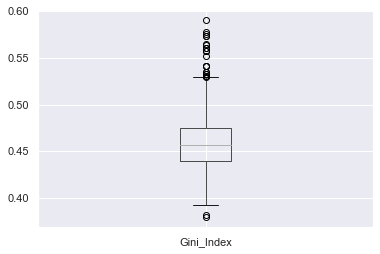

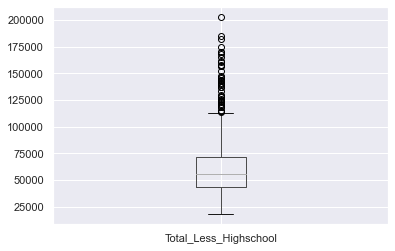

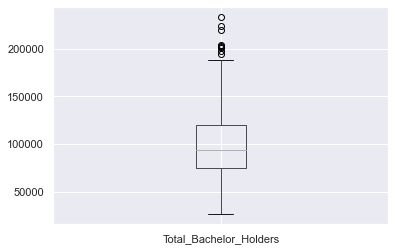

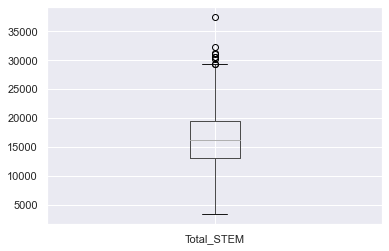

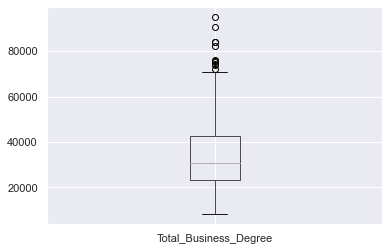

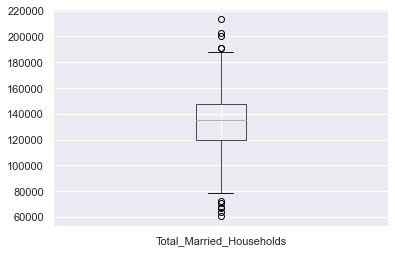

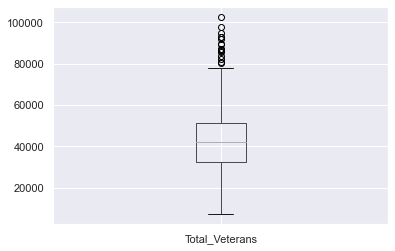

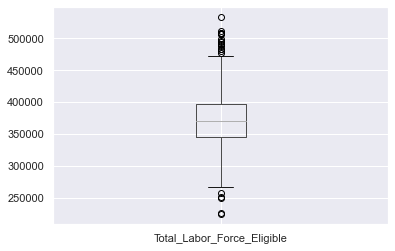

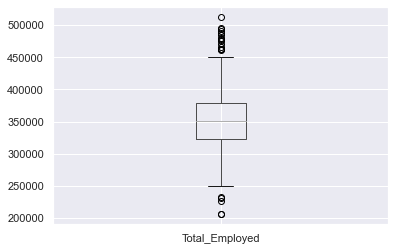

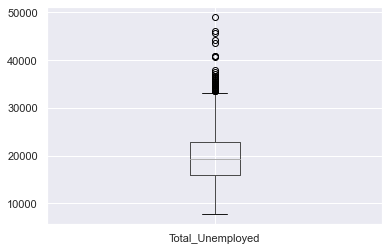

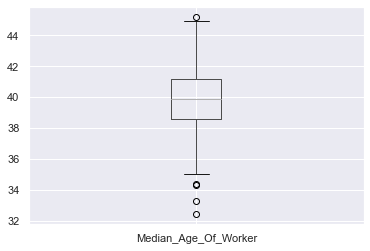

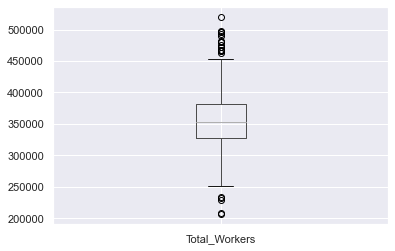

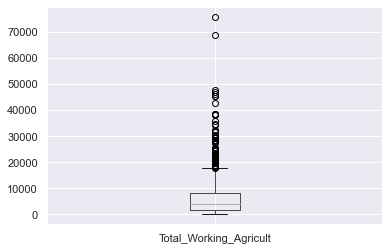

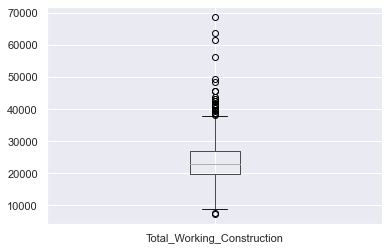

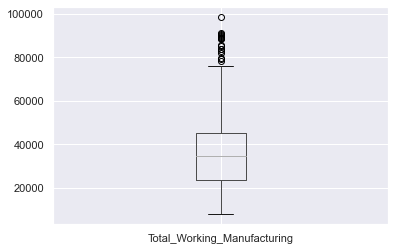

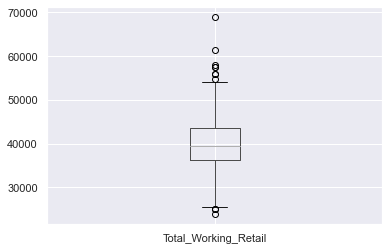

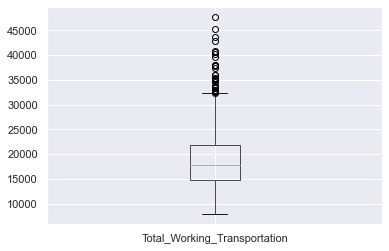

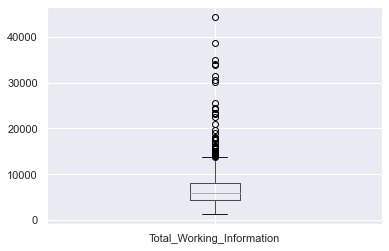

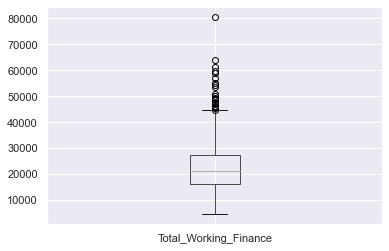

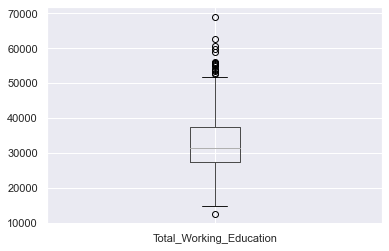

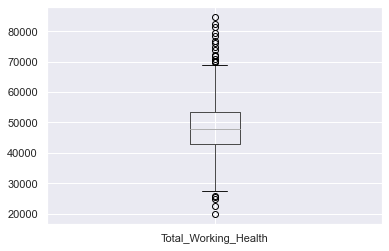

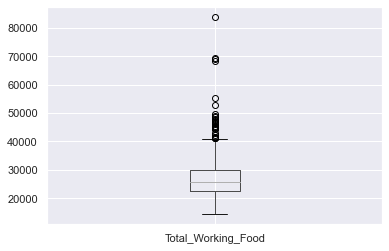

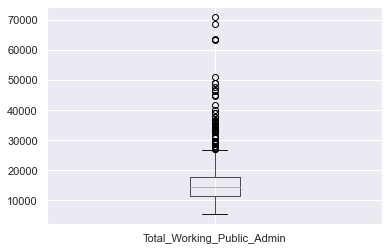

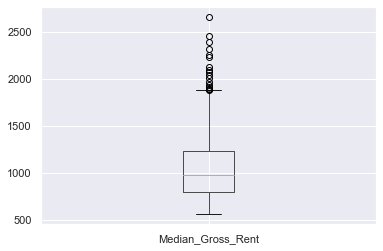

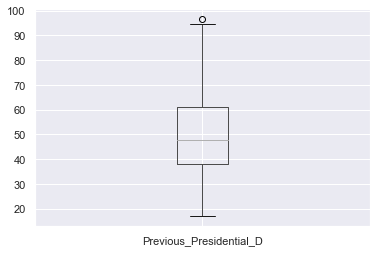

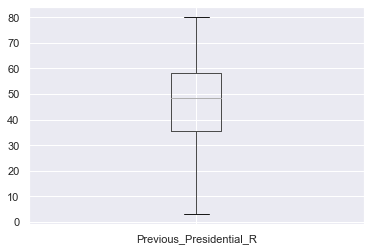

In [12]:
#Boxplots of all continuous variables as individual graphs
for i in election_df.columns[3:-1]:
    election_df.boxplot(column=i)
    plt.show()

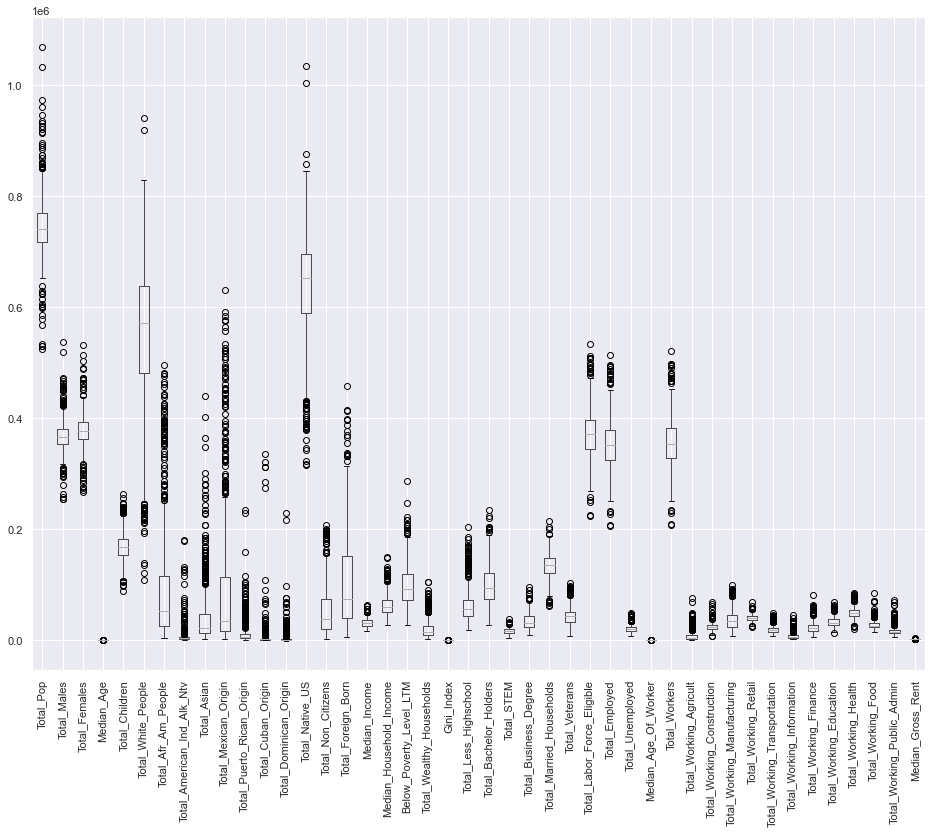

In [13]:
#A Boxplot of all continuous variables in one graph
election_df[['CD_Id_Year', 'District_Name', 'State', 'Total_Pop', 'Total_Males', 'Total_Females', 'Median_Age', 'Total_Children', 'Total_White_People', 'Total_Afr_Am_People', 'Total_American_Ind_Alk_Ntv', 'Total_Asian', 'Total_Mexican_Origin', 'Total_Puerto_Rican_Origin', 'Total_Cuban_Origin', 'Total_Dominican_Origin', 'Total_Native_US', 'Total_Non_Citizens', 'Total_Foreign_Born', 'Median_Income', 'Median_Household_Income', 'Below_Poverty_Level_LTM', 'Total_Wealthy_Households', 'Gini_Index', 'Total_Less_Highschool', 'Total_Bachelor_Holders', 'Total_STEM', 'Total_Business_Degree', 'Total_Married_Households', 'Total_Veterans', 'Total_Labor_Force_Eligible', 'Total_Employed', 'Total_Unemployed', 'Median_Age_Of_Worker', 'Total_Workers', 'Total_Working_Agricult', 'Total_Working_Construction', 'Total_Working_Manufacturing', 'Total_Working_Retail', 'Total_Working_Transportation', 'Total_Working_Information', 'Total_Working_Finance', 'Total_Working_Education', 'Total_Working_Health', 'Total_Working_Food', 'Total_Working_Public_Admin', 'Median_Gross_Rent']].boxplot(figsize = (16,12), rot= 90)

## 3. Feature Engineering

In [14]:
election_df.describe()

,Total_Pop,Total_Males,Total_Females,Median_Age,Total_Children,Total_White_People,Total_Afr_Am_People,Total_American_Ind_Alk_Ntv,Total_Asian,Total_Mexican_Origin,...,Total_Working_Information,Total_Working_Finance,Total_Working_Education,Total_Working_Health,Total_Working_Food,Total_Working_Public_Admin,Median_Gross_Rent,Previous_Presidential_D,Previous_Presidential_R,Target_Presidential_R_bool
count,8.040000e+02,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,...,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000
mean,7.466858e+05,367827.646766,378858.186567,38.372761,169345.966418,543699.912935,92014.589552,6546.079602,41601.274876,89479.240050,...,6967.060945,22991.623134,32592.481343,48525.524876,26916.460199,15979.069652,1056.809701,50.294279,46.394776,0.502488
std,5.332107e+04,27298.236632,27737.082779,3.711363,25954.358552,127621.087458,101141.428655,15567.032769,52246.304646,121152.048806,...,4483.561393,9375.616388,7643.917343,8593.275744,6952.916301,7477.454513,324.855768,16.084623,15.951706,0.500305
min,5.237410e+05,253674.000000,267332.000000,27.500000,87464.000000,108156.000000,3730.000000,195.000000,2235.000000,904.000000,...,1205.000000,4452.000000,12376.000000,19790.000000,14266.000000,5364.000000,558.000000,16.900000,3.000000,0.000000
25%,7.176530e+05,353222.000000,362832.500000,36.100000,152251.500000,481601.250000,25874.000000,1675.750000,12170.250000,15855.750000,...,4303.750000,16024.750000,27435.250000,42823.250000,22500.500000,11556.000000,800.750000,38.000000,35.600000,0.000000
50%,7.410345e+05,364936.500000,376176.000000,38.200000,166839.000000,570768.500000,52923.500000,2904.000000,22340.500000,33819.500000,...,5791.000000,21122.500000,31341.000000,48003.500000,25521.000000,14369.000000,975.000000,47.950000,48.650000,1.000000
75%,7.702305e+05,380232.250000,393222.750000,40.500000,182391.250000,637527.000000,115900.250000,5264.250000,47335.000000,112623.750000,...,8109.250000,27521.500000,37345.500000,53461.250000,29928.750000,17679.500000,1235.250000,61.225000,58.400000,1.000000
max,1.068778e+06,537170.000000,531608.000000,56.000000,263364.000000,940423.000000,494566.000000,180019.000000,439547.000000,630333.000000,...,44444.000000,80628.000000,69003.000000,84767.000000,84017.000000,71064.000000,2663.000000,96.700000,80.200000,1.000000


In [15]:
#In this cell I turn subsets of the total population into percentages of the
#population and  workforce/labor force

#Identify columns to divide by population segemnts

to_divide_by_total_pop = ['Total_Males', 'Total_Females', 'Total_Veterans', 'Total_White_People', 'Total_Afr_Am_People', 'Total_Asian', 'Total_American_Ind_Alk_Ntv', 'Total_Cuban_Origin', 'Total_Puerto_Rican_Origin', 'Total_Dominican_Origin', 'Total_Mexican_Origin', 'Total_Native_US', 'Total_Non_Citizens', 'Total_Foreign_Born', 'Total_Children', 'Total_Married_Households', 'Total_Less_Highschool', 'Total_Bachelor_Holders', 'Total_STEM', 'Total_Business_Degree', 'Total_Labor_Force_Eligible', 'Below_Poverty_Level_LTM', 'Total_Workers']
to_divide_by_total_labor_force_eligible = ['Total_Employed', 'Total_Unemployed']
to_divide_by_total_workers = ['Total_Working_Agricult', 'Total_Working_Construction', 'Total_Working_Manufacturing', 'Total_Working_Retail', 'Total_Working_Transportation', 'Total_Working_Finance', 'Total_Working_Education', 'Total_Working_Health', 'Total_Working_Food', 'Total_Working_Public_Admin', 'Total_Working_Information']

#Normalize the data by making certain columns a percentage of one of the three main population groups

election_df[to_divide_by_total_workers] = election_df[to_divide_by_total_workers].div(election_df['Total_Workers'], axis=0)
election_df[to_divide_by_total_labor_force_eligible] = election_df[to_divide_by_total_labor_force_eligible].div(election_df['Total_Labor_Force_Eligible'], axis=0)
election_df[to_divide_by_total_pop] = election_df[to_divide_by_total_pop].div(election_df['Total_Pop'], axis=0)

In [16]:
#I create a second dataframe made of my engineered features and compare the results of
#each dataframe
election_df_feature_engineering = election_df.copy()
election_df_feature_engineering.columns

Index(['CD_Id_Year', 'District_Name', 'State', 'Total_Pop', 'Total_Males',
       'Total_Females', 'Median_Age', 'Total_Children', 'Total_White_People',
       'Total_Afr_Am_People', 'Total_American_Ind_Alk_Ntv', 'Total_Asian',
       'Total_Mexican_Origin', 'Total_Puerto_Rican_Origin',
       'Total_Cuban_Origin', 'Total_Dominican_Origin', 'Total_Native_US',
       'Total_Non_Citizens', 'Total_Foreign_Born', 'Median_Income',
       'Median_Household_Income', 'Below_Poverty_Level_LTM',
       'Total_Wealthy_Households', 'Gini_Index', 'Total_Less_Highschool',
       'Total_Bachelor_Holders', 'Total_STEM', 'Total_Business_Degree',
       'Total_Married_Households', 'Total_Veterans',
       'Total_Labor_Force_Eligible', 'Total_Employed', 'Total_Unemployed',
       'Median_Age_Of_Worker', 'Total_Workers', 'Total_Working_Agricult',
       'Total_Working_Construction', 'Total_Working_Manufacturing',
       'Total_Working_Retail', 'Total_Working_Transportation',
       'Total_Working_Informat

In [17]:
#Create booleans if more than ten percent of a district's labor force work in a specific industry
election_df_feature_engineering['Ten_Percent_Manufacturing'] = np.where(election_df_feature_engineering['Total_Working_Manufacturing']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Manufacturing.value_counts())

election_df_feature_engineering['Ten_Percent_Agricult'] = np.where(election_df_feature_engineering['Total_Working_Agricult']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Agricult.value_counts())

election_df_feature_engineering['Ten_Percent_Construction'] = np.where(election_df_feature_engineering['Total_Working_Construction']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Construction.value_counts())

election_df_feature_engineering['Ten_Percent_Retail'] = np.where(election_df_feature_engineering['Total_Working_Retail']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Retail.value_counts())

election_df_feature_engineering['Ten_Percent_Information'] = np.where(election_df_feature_engineering['Total_Working_Information']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Information.value_counts())

election_df_feature_engineering['Ten_Percent_Transportation'] = np.where(election_df_feature_engineering['Total_Working_Transportation']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Transportation.value_counts())

election_df_feature_engineering['Ten_Percent_Finance'] = np.where(election_df_feature_engineering['Total_Working_Finance']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Finance.value_counts())

election_df_feature_engineering['Ten_Percent_Education'] = np.where(election_df_feature_engineering['Total_Working_Education']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Education.value_counts())

election_df_feature_engineering['Ten_Percent_Health'] = np.where(election_df_feature_engineering['Total_Working_Health']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Health.value_counts())

election_df_feature_engineering['Ten_Percent_Food'] = np.where(election_df_feature_engineering['Total_Working_Food']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Food.value_counts())


#Drops the columns that the above booleans were derived from
election_df_feature_engineering.drop(['Total_Working_Agricult',
       'Total_Working_Construction', 'Total_Working_Manufacturing',
       'Total_Working_Retail', 'Total_Working_Transportation',
       'Total_Working_Information', 'Total_Working_Finance',
       'Total_Working_Education', 'Total_Working_Health', 'Total_Working_Food',
       'Total_Working_Public_Admin'], axis=1)


0    427
1    377
Name: Ten_Percent_Manufacturing, dtype: int64
0    792
1     12
Name: Ten_Percent_Agricult, dtype: int64
0    774
1     30
Name: Ten_Percent_Construction, dtype: int64
1    673
0    131
Name: Ten_Percent_Retail, dtype: int64
0    803
1      1
Name: Ten_Percent_Information, dtype: int64
0    792
1     12
Name: Ten_Percent_Transportation, dtype: int64
0    755
1     49
Name: Ten_Percent_Finance, dtype: int64
0    570
1    234
Name: Ten_Percent_Education, dtype: int64
1    768
0     36
Name: Ten_Percent_Health, dtype: int64
0    746
1     58
Name: Ten_Percent_Food, dtype: int64


,CD_Id_Year,District_Name,State,Total_Pop,Total_Males,Total_Females,Median_Age,Total_Children,Total_White_People,Total_Afr_Am_People,...,Ten_Percent_Manufacturing,Ten_Percent_Agricult,Ten_Percent_Construction,Ten_Percent_Retail,Ten_Percent_Information,Ten_Percent_Transportation,Ten_Percent_Finance,Ten_Percent_Education,Ten_Percent_Health,Ten_Percent_Food
0,MD-08-2016,"Congressional District 8 (114th Congress), Mar...",MD,761778,0.483474,0.516526,40.0,0.222494,0.664476,0.120504,...,0,0,0,0,0,0,0,1,1,0
1,MA-01-2016,"Congressional District 1 (114th Congress), Mas...",MA,736190,0.481931,0.518069,41.0,0.208301,0.851639,0.062718,...,1,0,0,1,0,0,0,1,1,0
2,MA-02-2016,"Congressional District 2 (114th Congress), Mas...",MA,744886,0.488617,0.511383,39.1,0.201184,0.839923,0.053289,...,1,0,0,1,0,0,0,1,1,0
3,MA-03-2016,"Congressional District 3 (114th Congress), Mas...",MA,754068,0.493592,0.506408,39.0,0.231373,0.778707,0.034130,...,1,0,0,0,0,0,0,1,1,0
4,MA-04-2016,"Congressional District 4 (114th Congress), Mas...",MA,750331,0.486244,0.513756,40.9,0.228126,0.870159,0.028529,...,0,0,0,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,WI-05-2020,"Congressional District 5 (116th Congress), Wis...",WI,733314,0.493493,0.506507,42.5,0.203622,0.904964,0.024388,...,1,0,0,1,0,0,0,0,1,0
800,WI-06-2020,"Congressional District 6 (116th Congress), Wis...",WI,715828,0.499929,0.500071,42.0,0.209514,0.916085,0.019580,...,1,0,0,1,0,0,0,0,1,0
801,WI-07-2020,"Congressional District 7 (116th Congress), Wis...",WI,714544,0.504396,0.495604,45.0,0.212901,0.931979,0.008040,...,1,0,0,1,0,0,0,0,1,0
802,WI-08-2020,"Congressional District 8 (116th Congress), Wis...",WI,736079,0.499152,0.500848,40.8,0.222214,0.889944,0.016547,...,1,0,0,1,0,0,0,0,1,0


In [18]:
#Drop the original columns that the threshold columns were created from
election_df_feature_engineering = election_df_feature_engineering.drop(['Total_Working_Agricult',
       'Total_Working_Construction', 'Total_Working_Manufacturing',
       'Total_Working_Retail', 'Total_Working_Transportation',
       'Total_Working_Information', 'Total_Working_Finance',
       'Total_Working_Education', 'Total_Working_Health', 'Total_Working_Food',
       'Total_Working_Public_Admin'], axis=1)

#Drop the information boolean column because no district contains more than ten
#percent of the labor force working in that field
election_df_feature_engineering = election_df_feature_engineering.drop(['Ten_Percent_Information'], axis=1)

In [19]:
election_df_feature_engineering.columns

Index(['CD_Id_Year', 'District_Name', 'State', 'Total_Pop', 'Total_Males',
       'Total_Females', 'Median_Age', 'Total_Children', 'Total_White_People',
       'Total_Afr_Am_People', 'Total_American_Ind_Alk_Ntv', 'Total_Asian',
       'Total_Mexican_Origin', 'Total_Puerto_Rican_Origin',
       'Total_Cuban_Origin', 'Total_Dominican_Origin', 'Total_Native_US',
       'Total_Non_Citizens', 'Total_Foreign_Born', 'Median_Income',
       'Median_Household_Income', 'Below_Poverty_Level_LTM',
       'Total_Wealthy_Households', 'Gini_Index', 'Total_Less_Highschool',
       'Total_Bachelor_Holders', 'Total_STEM', 'Total_Business_Degree',
       'Total_Married_Households', 'Total_Veterans',
       'Total_Labor_Force_Eligible', 'Total_Employed', 'Total_Unemployed',
       'Median_Age_Of_Worker', 'Total_Workers', 'Median_Gross_Rent',
       'Previous_Presidential_D', 'Previous_Presidential_R',
       'Target_Presidential_R_bool', 'Ten_Percent_Manufacturing',
       'Ten_Percent_Agricult', 'Ten_Per

In [20]:
#Reorganize the second dataframe
election_df_feature_engineering = election_df_feature_engineering[['CD_Id_Year', 'District_Name', 'State', 'Total_Pop', 'Total_Males',
       'Total_Females', 'Median_Age', 'Total_Children', 'Total_White_People',
       'Total_Afr_Am_People', 'Total_American_Ind_Alk_Ntv', 'Total_Asian',
       'Total_Mexican_Origin', 'Total_Puerto_Rican_Origin',
       'Total_Cuban_Origin', 'Total_Dominican_Origin', 'Total_Native_US',
       'Total_Non_Citizens', 'Total_Foreign_Born', 'Median_Income',
       'Median_Household_Income', 'Below_Poverty_Level_LTM',
       'Total_Wealthy_Households', 'Gini_Index', 'Total_Less_Highschool',
       'Total_Bachelor_Holders', 'Total_STEM', 'Total_Business_Degree',
       'Total_Married_Households', 'Total_Veterans',
       'Total_Labor_Force_Eligible', 'Total_Employed', 'Total_Unemployed',
       'Median_Age_Of_Worker', 'Total_Workers', 'Ten_Percent_Manufacturing',
       'Ten_Percent_Agricult', 'Ten_Percent_Construction',
       'Ten_Percent_Retail', 'Ten_Percent_Transportation',
       'Ten_Percent_Finance', 'Ten_Percent_Education', 'Ten_Percent_Health',
       'Ten_Percent_Food', 'Median_Gross_Rent',
       'Previous_Presidential_D', 'Previous_Presidential_R', 'Target_Presidential_R_bool']]

## 4. A Function To Plot The Confusion Matrix

In [21]:
#This function will be used to create confusion matrices for each model where appropriate
def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    classes = ['Did Not Vote Republican', 'Voted Republican']
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print('Confusion Matrix')

    figure(figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size': 22})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## 5. Initial Regression - Without Feature Engineering

In [22]:
#This is an initial logistic regression of all dependent variables using Scikit learn
#Using the dataframe without feature engineering

#Split data to be used in the models between the target variable and features

# X will take every dependent variable but the target and other index variables
X_log_model_1 = election_df.drop(['Target_Presidential_R_bool','CD_Id_Year', 'District_Name', 'State'], axis = 1) 

#y will hold the target variable
y_log_model_1 = election_df['Target_Presidential_R_bool'] # y is the column we're trying to predict

In [23]:
#Split the data into a train and test set
X_train_log_model_1, X_test_log_model_1, y_train_log_model_1, y_test_log_model_1 = train_test_split(X_log_model_1, y_log_model_1, random_state=1)


sc_log_model_1=StandardScaler()
X_train_scaled_log_model_1 = sc_log_model_1.fit_transform(X_train_log_model_1)
X_test_scaled_log_model_1 = sc_log_model_1.transform(X_test_log_model_1)


In [24]:
#Fit the model and view the coefficients
log_model_1 = LogisticRegression(C=1e9)
log_model_1.fit(X_train_scaled_log_model_1, y_train_log_model_1)
zip(X_train_log_model_1.columns, log_model_1.coef_[0])
log_model_1.coef_

array([[ 3.55449806e+00,  1.84542383e+00, -1.84542383e+00,
         2.06065100e+01,  2.19381192e+01,  4.51966280e+01,
         3.73993189e+01,  9.94129803e+00,  6.73320656e-01,
         8.43110442e+00, -1.72204576e+00,  4.54815296e-02,
         2.73974583e+00,  9.14282622e+00, -5.22273960e+01,
         6.28636169e+01,  1.18170166e+01, -7.74635510e+01,
        -2.16265206e+01,  3.95877449e+01, -7.60744125e+00,
        -1.27719913e+01, -3.65691320e+01,  1.16782985e-01,
         6.48474257e+00,  1.54035692e+01, -1.49417769e+01,
         2.09210619e+00, -9.45445992e+00,  9.45445992e+00,
        -1.18463064e+01,  2.57002649e+01,  8.91916688e-01,
         8.43815898e+00,  7.33650811e+00,  8.45121409e+00,
         2.51346170e+00,  1.32483350e+01,  1.88317095e+00,
         1.22290255e+01,  8.06690573e+00,  8.69967228e+00,
         1.30423630e+01,  1.42905254e+01, -1.21624680e+01,
         6.74191507e+01]])

In [25]:
#Makes predictions on the train and test set
y_pred_class_log_model_1_train = log_model_1.predict(X_train_scaled_log_model_1)


#Calculate the model's accuracy and f1
print("The training accuracy is: " + str(metrics.accuracy_score(y_train_log_model_1, y_pred_class_log_model_1_train)))

print("The training f1 score is: " + str(metrics.f1_score(y_train_log_model_1, y_pred_class_log_model_1_train)))

The training accuracy is: 0.9933665008291874
The training f1 score is: 0.9934426229508196


In [26]:
#Class predictions on the test set (not predicted probabilities)
y_pred_class_log_model_1 = log_model_1.predict(X_test_scaled_log_model_1)

#Calculates the model's accuracy and f1
print("The testing accuracy is: " + str(metrics.accuracy_score(y_test_log_model_1, y_pred_class_log_model_1)))

print("The testing f1 score is: " + str(metrics.f1_score(y_test_log_model_1, y_pred_class_log_model_1)))

The testing accuracy is: 0.9502487562189055
The testing f1 score is: 0.9489795918367346


In [27]:
#Save confusion matrix and slice into four pieces
confusion_log_model_1 = metrics.confusion_matrix(y_test_log_model_1, y_pred_class_log_model_1)
TP_log_model_1 = confusion_log_model_1[1][1]
TN_log_model_1 = confusion_log_model_1[0][0]
FP_log_model_1 = confusion_log_model_1[0][1]
FN_log_model_1 = confusion_log_model_1[1][0]

print('Log Model 1 Confusion Matrix:')
print ('True Positives:', TP_log_model_1)
print ('True Negatives:', TN_log_model_1)
print ('False Positives:', FP_log_model_1)
print ('False Negatives:', FN_log_model_1)

Log Model 1 Confusion Matrix:
True Positives: 93
True Negatives: 98
False Positives: 4
False Negatives: 6


Confusion Matrix


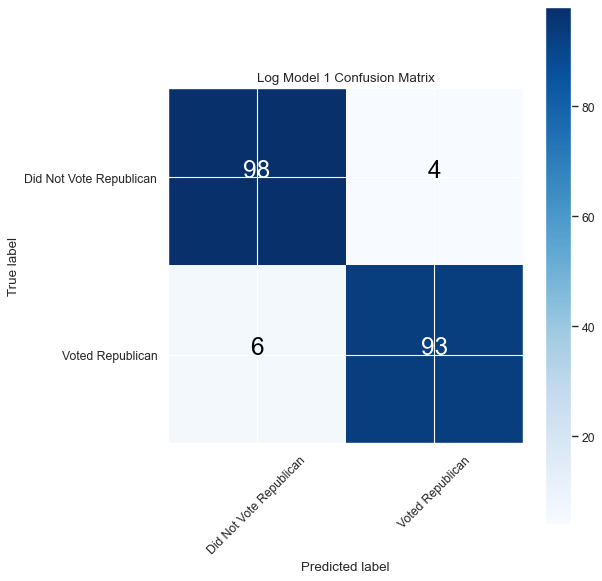

In [28]:
#Plot the confusion matrix
plot_confusion_matrix(confusion_log_model_1,
                          normalize=False,
                          title='Log Model 1 Confusion Matrix',
                          cmap=plt.cm.Blues)

## 6. Initial Regression - With Feature Engineering

In [29]:
#This is an initial logistic regression of all dependent variables using Scikit learn
#using the dataframe with feature engineering

#Split data to be used in the models between the target variable and features

# X will take every dependent variable but the target and other index variables
X_log_model_2 = election_df_feature_engineering.drop(['Target_Presidential_R_bool','CD_Id_Year', 'District_Name','State'], axis = 1) 

# Create target variable
y_log_model_2 = election_df_feature_engineering['Target_Presidential_R_bool'] # y is the column we're trying to predict

In [30]:
#Split the data into a train and test set
X_train_log_model_2, X_test_log_model_2, y_train_log_model_2, y_test_log_model_2 = train_test_split(X_log_model_2, y_log_model_2, random_state=1)


sc_log_model_2=StandardScaler()
X_train_scaled_log_model_2 = sc_log_model_2.fit_transform(X_train_log_model_2)
X_test_scaled_log_model_2 = sc_log_model_2.transform(X_test_log_model_2)


In [31]:
#Fit the model and view the coefficients
log_model_2 = LogisticRegression(C=1e9)
log_model_2.fit(X_train_scaled_log_model_2, y_train_log_model_2)
zip(X_train_log_model_2.columns, log_model_2.coef_[0])
log_model_2.coef_

array([[  1.81721614,   1.16848853,  -1.16848853,   3.55875756,
          4.49112064,  22.77463888,  20.86715341,   4.53454595,
          3.53716089,   2.1874599 ,   0.91187572,  -0.12764236,
          2.15387866,  28.12610148, -18.24481582,  45.19435289,
          3.05692333, -22.58800609,  -6.37859512,  10.85205863,
         -3.71438915,  -7.36589109, -13.67594967,   2.31404834,
         -0.33941853,   1.36778268,  -3.49574196, -30.77972259,
         -6.6993704 ,   6.6993704 ,   0.24701845,  40.39239687,
         -3.10538191,   2.53562318,  -0.68649124,   3.5047251 ,
          1.97548167,  -0.52435401,   1.39562781,  -1.12086385,
         -2.40330592,   5.93232287, -10.42675924,  26.70827713]])

In [32]:
#Makes predictions on the train and test set
y_pred_class_log_model_2_train = log_model_2.predict(X_train_scaled_log_model_2)


#Calculate the model's accuracy and f1 score
print("The training accuracy is: ", metrics.accuracy_score(y_train_log_model_2, y_pred_class_log_model_2_train))

print("The training f1 score is: ", metrics.f1_score(y_train_log_model_2, y_pred_class_log_model_2_train))

The training accuracy is:  0.9850746268656716
The training f1 score is:  0.9852216748768473


In [33]:
#Class predictions on the test set (not predicted probabilities)
y_pred_class_log_model_2 = log_model_2.predict(X_test_scaled_log_model_2)

#Calculate the model's accuracy and f1 score
print("The testing accuracy is: ", metrics.accuracy_score(y_test_log_model_2, y_pred_class_log_model_2))

print("The testing f1 score is: ", metrics.f1_score(y_test_log_model_2, y_pred_class_log_model_2))

The testing accuracy is:  0.945273631840796
The testing f1 score is:  0.945273631840796


In [34]:
#Save confusion matrix and slice into four pieces
confusion_log_model_2 = metrics.confusion_matrix(y_test_log_model_2, y_pred_class_log_model_2)
TP_log_model_2 = confusion_log_model_1[1][1]
TN_log_model_2 = confusion_log_model_1[0][0]
FP_log_model_2 = confusion_log_model_1[0][1]
FN_log_model_2 = confusion_log_model_1[1][0]

print('Log Model 2 Confusion Matrix:')
print ('True Positives:', TP_log_model_2)
print ('True Negatives:', TN_log_model_2)
print ('False Positives:', FP_log_model_2)
print ('False Negatives:', FN_log_model_2)

Log Model 2 Confusion Matrix:
True Positives: 93
True Negatives: 98
False Positives: 4
False Negatives: 6


Confusion Matrix


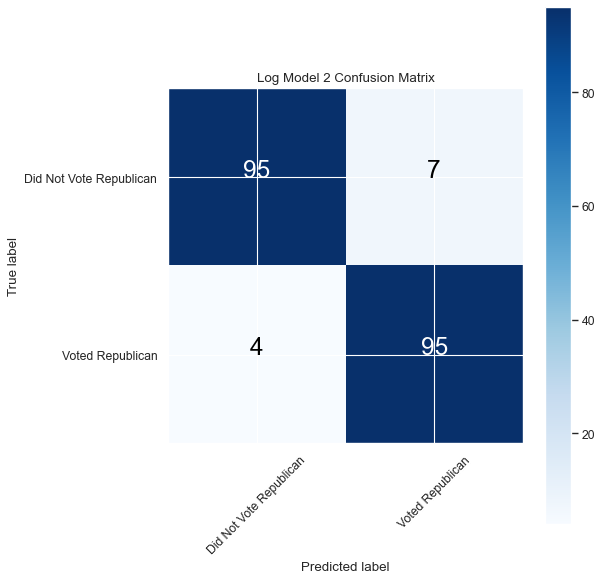

In [35]:
#Plot the confusion Matrix
plot_confusion_matrix(confusion_log_model_2,
                          normalize=False,
                          title='Log Model 2 Confusion Matrix',
                          cmap=plt.cm.Blues)

## 7. Logistic Model Grid Search

In [36]:
#The following is a function that resets the data for future use
def reset_data(df_to_use = None):
    
    if df_to_use == 'engineered':
        
        df = election_df_feature_engineering
        
        features_list = ['Total_Pop', 'Total_Males',
                         'Total_Females', 'Median_Age', 'Total_Children', 'Total_White_People',
                         'Total_Afr_Am_People', 'Total_American_Ind_Alk_Ntv', 'Total_Asian',
                         'Total_Mexican_Origin', 'Total_Puerto_Rican_Origin',
                         'Total_Cuban_Origin', 'Total_Dominican_Origin', 'Total_Native_US',
                         'Total_Non_Citizens', 'Total_Foreign_Born', 'Median_Income',
                         'Median_Household_Income', 'Below_Poverty_Level_LTM',
                         'Total_Wealthy_Households', 'Gini_Index', 'Total_Less_Highschool',
                         'Total_Bachelor_Holders', 'Total_STEM', 'Total_Business_Degree',
                         'Total_Married_Households', 'Total_Veterans',
                         'Total_Labor_Force_Eligible', 'Total_Employed', 'Total_Unemployed',
                         'Median_Age_Of_Worker', 'Total_Workers', 'Ten_Percent_Manufacturing',
                         'Ten_Percent_Agricult', 'Ten_Percent_Construction',
                         'Ten_Percent_Retail', 'Ten_Percent_Transportation',
                         'Ten_Percent_Finance', 'Ten_Percent_Education', 'Ten_Percent_Health',
                         'Ten_Percent_Food', 'Median_Gross_Rent',
                         'Previous_Presidential_D', 'Previous_Presidential_R']
    else:
        
        df = election_df
        
        features_list = ['Total_Pop', 'Total_Males',
                         'Total_Females', 'Median_Age', 'Total_Children', 'Total_White_People',
                         'Total_Afr_Am_People', 'Total_American_Ind_Alk_Ntv', 'Total_Asian',
                         'Total_Mexican_Origin', 'Total_Puerto_Rican_Origin', 'Total_Cuban_Origin',
                         'Total_Dominican_Origin', 'Total_Native_US', 'Total_Non_Citizens',
                         'Total_Foreign_Born', 'Median_Income', 'Median_Household_Income',
                         'Below_Poverty_Level_LTM', 'Total_Wealthy_Households', 'Gini_Index',
                         'Total_Less_Highschool', 'Total_Bachelor_Holders', 'Total_STEM',
                         'Total_Business_Degree', 'Total_Married_Households', 'Total_Veterans',
                         'Total_Labor_Force_Eligible', 'Total_Employed', 'Total_Unemployed',
                         'Median_Age_Of_Worker', 'Total_Workers', 'Total_Working_Agricult',
                         'Total_Working_Construction', 'Total_Working_Manufacturing',
                         'Total_Working_Retail', 'Total_Working_Transportation',
                         'Total_Working_Information', 'Total_Working_Finance', 
                         'Total_Working_Education', 'Total_Working_Health', 'Total_Working_Food',
                         'Total_Working_Public_Admin', 'Median_Gross_Rent', 'Previous_Presidential_D',
                         'Previous_Presidential_R']
    
    y = df.Target_Presidential_R_bool
    X = df[features_list]
    
    return train_test_split(X, y, random_state=1, test_size = 0.2)


In [37]:
#Splits the data for the logistic model gridsearch, using the standard features
X_train_log_model_3, X_test_log_model_3, y_train_log_model_3, y_test_log_model_3 =  reset_data()

sc_log_model_3=StandardScaler()
X_train_scaled_log_model_3= sc_log_model_3.fit_transform(X_train_log_model_3)
X_test_scaled_log_model_3 = sc_log_model_3.transform(X_test_log_model_3)

In [38]:
# Creates logistic regression model
log_model_3 = linear_model.LogisticRegression()

In [39]:
# Creates regularization penalty parameters
penalty = ['l1', 'l2']

# Creates regularization hyperparameters
C = C_param_range = [0.001,0.01,0.1, 0.5, 1, 2, 5, 10]

# Creates hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

In [40]:
# Creates a grid search using 5-fold cross validation
clf_gs_log_model_3 = GridSearchCV(log_model_3, hyperparameters, cv=5, scoring= "f1") 

In [41]:
# Fits grid search to the training data
log_model_3 = clf_gs_log_model_3.fit(X_train_scaled_log_model_3, y_train_log_model_3) 

In [42]:
# View best hyperparameters
print('Best Penalty:', log_model_3.best_estimator_.get_params()['penalty'])
print('Best C:', log_model_3.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 0.5


In [43]:
#Make predictions for scoring purposes
y_pred_train_log_model_3 = log_model_3.best_estimator_.predict(X_train_scaled_log_model_3)

y_pred_test_log_model_3 = log_model_3.best_estimator_.predict(X_test_scaled_log_model_3)

# Model accuracy and f1 scores
print("Training Accuracy for Log Model 3 (GS Standard Features):", metrics.accuracy_score(y_train_log_model_3, y_pred_train_log_model_3))
print("Training F1 Score for Log Model 3 (GS Standard Features):", metrics.f1_score(y_train_log_model_3, y_pred_train_log_model_3))
print("")
print("Testing Accuracy for Log Model 3 (GS Standard Features):", metrics.accuracy_score(y_test_log_model_3, y_pred_test_log_model_3))
print("Testing F1 Score for Log Model 3 (GS Standard Features):", metrics.f1_score(y_test_log_model_3, y_pred_test_log_model_3))

Training Accuracy for Log Model 3 (GS Standard Features): 0.9751166407465007
Training F1 Score for Log Model 3 (GS Standard Features): 0.9752321981424149

Testing Accuracy for Log Model 3 (GS Standard Features): 0.9503105590062112
Testing F1 Score for Log Model 3 (GS Standard Features): 0.9512195121951219


In [44]:
# Sorts feature importances in descending order and displays the top 10

model_params_log_model_3 = list(zip(list(X_train_log_model_3.columns), log_model_3.best_estimator_.coef_[0]))

model_params_log_model_3.sort(key = lambda x: abs(x[1]), reverse=True)
model_params_log_model_3[:10]

[('Previous_Presidential_R', 2.86078364341137),
 ('Previous_Presidential_D', -2.4464476225494103),
 ('Total_Mexican_Origin', -0.6445716553127999),
 ('Total_Non_Citizens', -0.5806860434422716),
 ('Total_Married_Households', 0.5371311619880528),
 ('Total_Bachelor_Holders', -0.505847866707848),
 ('Total_Working_Education', 0.48995923207016884),
 ('Total_Dominican_Origin', 0.4547563769379519),
 ('Median_Age_Of_Worker', 0.44873977225602624),
 ('Median_Household_Income', -0.44774347632786005)]

<Figure size 432x288 with 0 Axes>

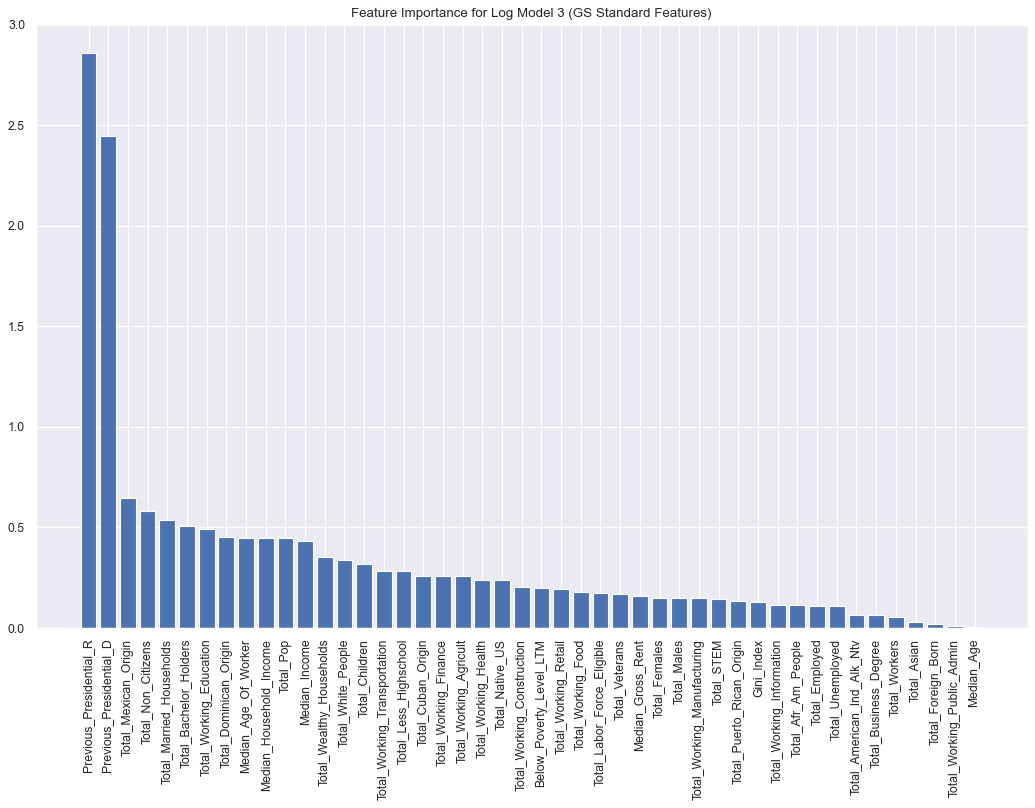

In [45]:
#Plots the parameter importance

# Rearrange feature names so they match the sorted feature importances
model_features_log_model_3 = [i[0] for i in model_params_log_model_3]

feature_weights_log_model_3 = [abs(i[1]) for i in model_params_log_model_3]

# Creates the plot

plt.figure()
figure(figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
# Creates the plot title
plt.title("Feature Importance for Log Model 3 (GS Standard Features)")

# Add bars
plt.bar(model_features_log_model_3, feature_weights_log_model_3)

# Add feature names as x-axis labels
plt.xticks(rotation=90)

# Show plot
plt.show()

In [46]:
# View confusion matrix and slice into four pieces

confusion_log_model_3 = metrics.confusion_matrix(y_test_log_model_3, y_pred_test_log_model_3)
TP_log_model_3 = confusion_log_model_3[1][1]
TN_log_model_3 = confusion_log_model_3[0][0]
FP_log_model_3 = confusion_log_model_3[0][1]
FN_log_model_3 = confusion_log_model_3[1][0]

print('Log Model 3 Confusion Matrix:')
print ('True Positives:', TP_log_model_3)
print ('True Negatives:', TN_log_model_3)
print ('False Positives:', FP_log_model_3)
print ('False Negatives:', FN_log_model_3)

Log Model 3 Confusion Matrix:
True Positives: 78
True Negatives: 75
False Positives: 5
False Negatives: 3


Confusion Matrix


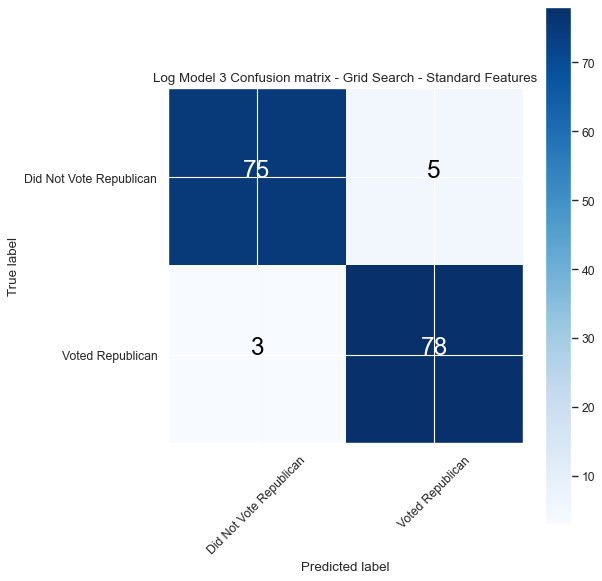

In [47]:
#Plots the confusion matrix visualization
confusion_log_model_3 = metrics.confusion_matrix(y_test_log_model_3, y_pred_test_log_model_3)

plot_confusion_matrix(confusion_log_model_3, title='Log Model 3 Confusion matrix - Grid Search - Standard Features')


## 8. Logistic Model Grid Search With Engineered Features

In [48]:
#Splits the data for the logistic model gridsearch, using the engineered features
X_train_log_model_4, X_test_log_model_4, y_train_log_model_4, y_test_log_model_4 =  reset_data('engineered')

sc_log_model_4=StandardScaler()
X_train_scaled_log_model_4= sc_log_model_4.fit_transform(X_train_log_model_4)
X_test_scaled_log_model_4 = sc_log_model_4.transform(X_test_log_model_4)

# Create logistic regression model
log_model_4 = linear_model.LogisticRegression()

# Create grid search using 5-fold cross validation, same parameters as before
clf_gs_log_model_4 = GridSearchCV(log_model_4, hyperparameters, cv=5, scoring= "f1") 

# Fit grid search
log_model_4 = clf_gs_log_model_4.fit(X_train_scaled_log_model_4, y_train_log_model_4)



In [49]:
# View best hyperparameters
print('Best Penalty:', log_model_4.best_estimator_.get_params()['penalty'])
print('Best C:', log_model_4.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 0.5


In [50]:
#Make predictions for scoring purposes

y_pred_train_log_model_4 = log_model_4.best_estimator_.predict(X_train_scaled_log_model_4)

y_pred_test_log_model_4 = log_model_4.best_estimator_.predict(X_test_scaled_log_model_4)

# Model accuracy and f1 scores
print("Training Accuracy for Log Model 4 (GS Engineered Features):", metrics.accuracy_score(y_train_log_model_4, y_pred_train_log_model_4))
print("Training F1 Score for Log Model 4 (GS Engineered Features):", metrics.f1_score(y_train_log_model_4, y_pred_train_log_model_4))
print("")
print("Testing Accuracy for Log Model 4 (GS Engineered Features):", metrics.accuracy_score(y_test_log_model_4, y_pred_test_log_model_4))
print("Testing F1 Score for Log Model 4 (GS Engineered Features):", metrics.f1_score(y_test_log_model_4, y_pred_test_log_model_4))

Training Accuracy for Log Model 4 (GS Engineered Features): 0.9766718506998445
Training F1 Score for Log Model 4 (GS Engineered Features): 0.9767441860465117

Testing Accuracy for Log Model 4 (GS Engineered Features): 0.9440993788819876
Testing F1 Score for Log Model 4 (GS Engineered Features): 0.9454545454545454


In [51]:
# Sorts feature importances in descending order and displays the top 10

model_params_log_model_4 = list(zip(list(X_train_log_model_4.columns), log_model_4.best_estimator_.coef_[0]))

model_params_log_model_4.sort(key = lambda x: abs(x[1]), reverse=True)
model_params_log_model_4[:10]

[('Previous_Presidential_R', 2.882139452734107),
 ('Previous_Presidential_D', -2.4401412552757935),
 ('Total_Bachelor_Holders', -0.6938669187063253),
 ('Total_Mexican_Origin', -0.6803187448845498),
 ('Total_Non_Citizens', -0.5888652433852172),
 ('Total_Married_Households', 0.5404128989839431),
 ('Median_Age_Of_Worker', 0.4540397847180845),
 ('Total_Dominican_Origin', 0.448681476132835),
 ('Total_White_People', 0.42693742170840476),
 ('Total_Pop', 0.3918229163917311)]

<Figure size 432x288 with 0 Axes>

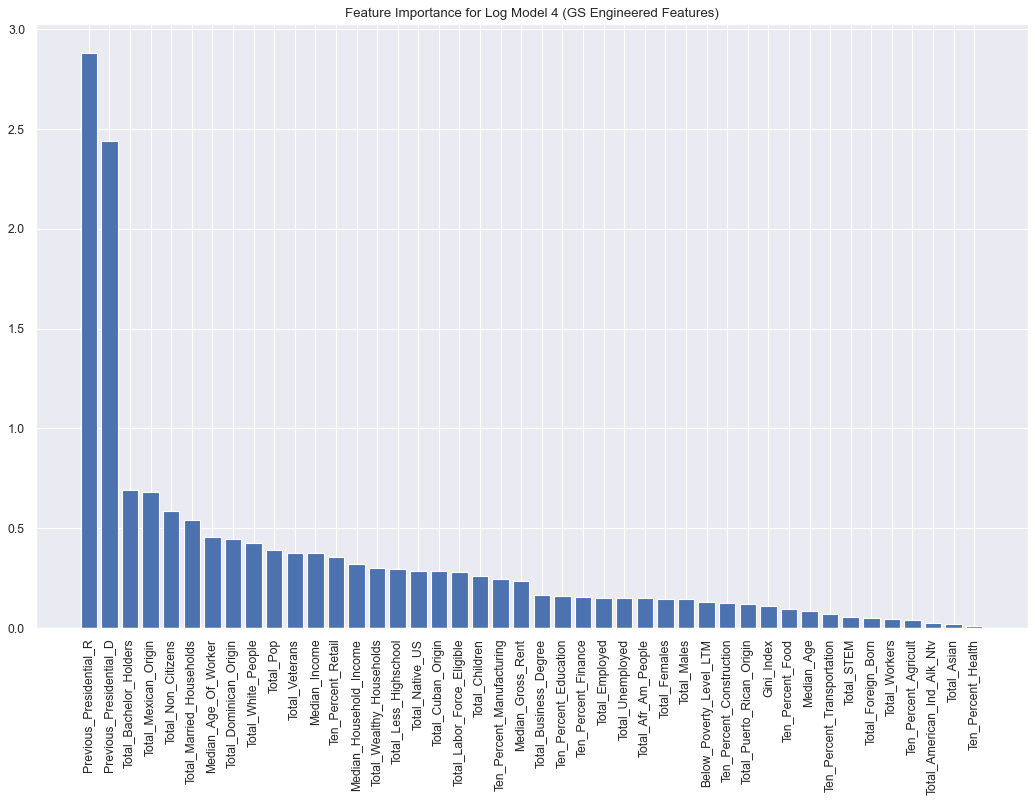

In [52]:
#Plot the parameter importance

# Rearrange feature names so they match the sorted feature importances
model_features_log_model_4 = [i[0] for i in model_params_log_model_4]

feature_weights_log_model_4 = [abs(i[1]) for i in model_params_log_model_4]

# Create plot

plt.figure()
figure(figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
# Create plot title
plt.title("Feature Importance for Log Model 4 (GS Engineered Features)")

# Add bars
plt.bar(model_features_log_model_4, feature_weights_log_model_4)

# Add feature names as x-axis labels
plt.xticks(rotation=90)

# Show plot
plt.show()

Confusion Matrix


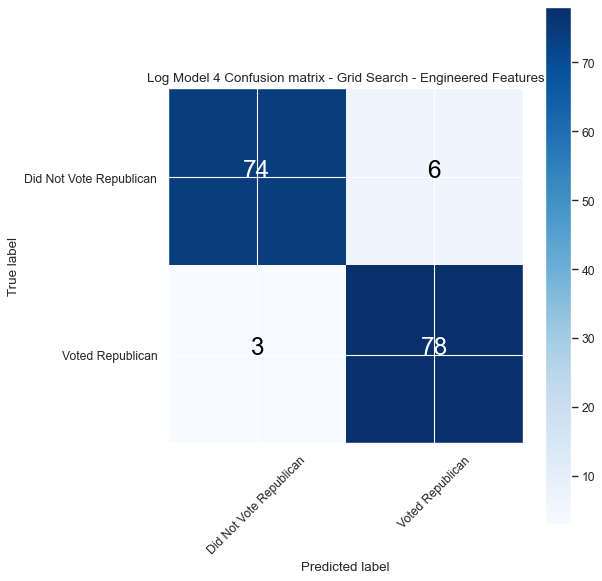

In [53]:
#View the confusion matrix
confusion_log_model_4 = metrics.confusion_matrix(y_test_log_model_4, y_pred_test_log_model_4)
plot_confusion_matrix(confusion_log_model_4, title='Log Model 4 Confusion matrix - Grid Search - Engineered Features')

## 9. Logistic Model Grid Search On The Standard Set- With Polynomials

In [54]:
#Create a pipeline for a polynomial grid search
pipe_lr_poly = Pipeline([('poly', PolynomialFeatures(degree=3)),
            ('scl', StandardScaler()),
            ('clf', LogisticRegression(random_state=42))])

In [55]:
#Sets up the parameters to search through
penalty_param_range_lr_poly = [1.0, 0.5, 0.1, .01]

grid_params_lr_poly = [{'clf__penalty': ['l1', 'l2'], 'clf__C': penalty_param_range_lr_poly, 'clf__solver': ['liblinear']}] 



In [56]:
#Splits the data for the polynomial logistic model gridsearch, using the standard features
X_train_log_model_5, X_test_log_model_5, y_train_log_model_5, y_test_log_model_5 =  reset_data()

sc_log_model_5=StandardScaler()
X_train_scaled_log_model_5= sc_log_model_5.fit_transform(X_train_log_model_5)
X_test_scaled_log_model_5 = sc_log_model_5.transform(X_test_log_model_5)

In [57]:
#Fits the model
log_model_5 = GridSearchCV(estimator=pipe_lr_poly, param_grid=grid_params_lr_poly, scoring='f1', cv=10)
#I've taken out the parameter 'verbose=5' to neaten up the notebook
log_model_5.fit(X_train_scaled_log_model_5, y_train_log_model_5)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                                       ('scl', StandardScaler()),
                                       ('clf',
                                        LogisticRegression(random_state=42))]),
             param_grid=[{'clf__C': [1.0, 0.5, 0.1, 0.01],
                          'clf__penalty': ['l1', 'l2'],
                          'clf__solver': ['liblinear']}],
             scoring='f1')

In [58]:
#Loading the saved model with pickle
#log_model_5_pkl = open('./Classification_Models_After_log_model_5.pkl', 'rb')
#log_model_5 = pickle.load(log_model_5_pkl)
#print("Loaded log_model_5 Pickle :: ", log_model_5)

In [59]:
# Best params
print('Best params: %s' % log_model_5.best_params_)
# Best training data accuracy
print('Best training accuracy: %.3f' % log_model_5.best_score_)
# Predict on test data with best params
y_pred_test_log_model_5 = log_model_5.predict(X_test_scaled_log_model_5)
# Test data accuracy of model with best params
print('Test set F1 score for best params: %.4f ' % f1_score(y_test_log_model_5, y_pred_test_log_model_5))

Best params: {'clf__C': 0.5, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best training accuracy: 0.954
Test set F1 score for best params: 0.9448 


In [60]:
#Make predictions for scoring purposes
y_pred_train_log_model_5 = log_model_5.predict(X_train_scaled_log_model_5)

# Model accuracy and f1 scores
print("Training Accuracy for Log Model 5 (GS Polynomials Standard Features):", accuracy_score(y_train_log_model_5, y_pred_train_log_model_5))
print("Training F1 Score for Log Model 5 (GS Polynomials Standard Features):", f1_score(y_train_log_model_5, y_pred_train_log_model_5))
print("")
print("Testing Accuracy for Log Model 5 (GS Polynomials Standard Features):", accuracy_score(y_test_log_model_5, y_pred_test_log_model_5))
print("Testing F1 Score for Log Model 5 (GS Polynomials Standard Features):", f1_score(y_test_log_model_5, y_pred_test_log_model_5))

Training Accuracy for Log Model 5 (GS Polynomials Standard Features): 0.9968895800933126
Training F1 Score for Log Model 5 (GS Polynomials Standard Features): 0.9969040247678018

Testing Accuracy for Log Model 5 (GS Polynomials Standard Features): 0.9440993788819876
Testing F1 Score for Log Model 5 (GS Polynomials Standard Features): 0.9447852760736196


Confusion Matrix


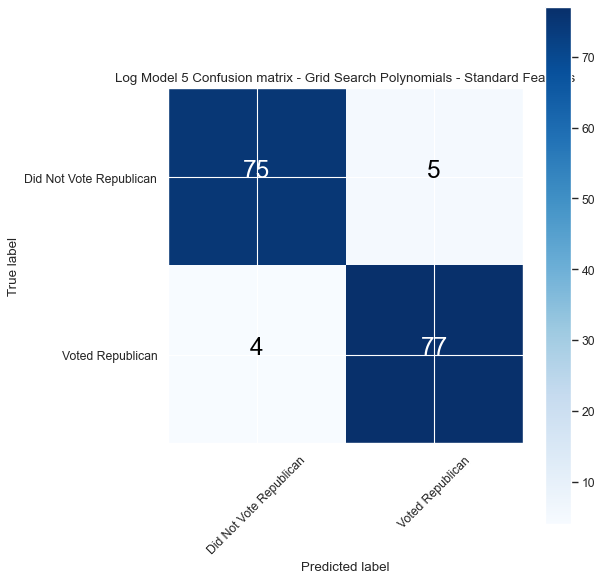

In [61]:
#View the confusion matrix
confusion_log_model_5 = metrics.confusion_matrix(y_test_log_model_5, y_pred_test_log_model_5)
plot_confusion_matrix(confusion_log_model_5, title='Log Model 5 Confusion matrix - Grid Search Polynomials - Standard Features')

In [62]:
#Run this code to save the model data
#make_pickle(log_model_5, 'log_model_5')

## 10. Logistic Model Grid Search On The Engineered Set- With Polynomials

In [63]:
#Splits the data for the polynomial logistic model gridsearch, using the engineered features
X_train_log_model_6, X_test_log_model_6, y_train_log_model_6, y_test_log_model_6 =  reset_data('engineered')

sc_log_model_6=StandardScaler()
X_train_scaled_log_model_6= sc_log_model_6.fit_transform(X_train_log_model_6)
X_test_scaled_log_model_6 = sc_log_model_6.transform(X_test_log_model_6)

In [64]:
log_model_6 = GridSearchCV(estimator=pipe_lr_poly, param_grid=grid_params_lr_poly, scoring='f1', cv=10)
#I've taken out the parameter 'verbose=5' to neaten up the notebook
log_model_6.fit(X_train_scaled_log_model_6, y_train_log_model_6)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                                       ('scl', StandardScaler()),
                                       ('clf',
                                        LogisticRegression(random_state=42))]),
             param_grid=[{'clf__C': [1.0, 0.5, 0.1, 0.01],
                          'clf__penalty': ['l1', 'l2'],
                          'clf__solver': ['liblinear']}],
             scoring='f1')

In [65]:
#Loading the saved polynomial logistic model with pickle
#log_model_6_pkl = open('./Classification_Models_After_log_model_6.pkl', 'rb')
#log_model_6 = pickle.load(log_model_6_pkl)
#print("Loaded log_model_6 Pickle :: ", log_model_6)

In [66]:
# Best params
print('Best params: %s' % log_model_6.best_params_)
# Best training data accuracy
print('Best training accuracy: %.3f' % log_model_5.best_score_)
# Predict on test data with best params
y_pred_test_log_model_6 = log_model_6.predict(X_test_scaled_log_model_6)
# Test data accuracy of model with best params
print('Test set F1 score for best params: %.4f ' % f1_score(y_test_log_model_6, y_pred_test_log_model_6))

Best params: {'clf__C': 0.1, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best training accuracy: 0.954
Test set F1 score for best params: 0.9390 


In [67]:
#Make predictions for scoring purposes
y_pred_train_log_model_6 = log_model_6.predict(X_train_scaled_log_model_6)

# Prints the accuracy and f1 scores
print("Training Accuracy for Log Model 6 (GS Polynomials Engineered Features):", accuracy_score(y_train_log_model_6, y_pred_train_log_model_6))
print("Training F1 Score for Log Model 6 (GS Polynomials Engineered Features):", f1_score(y_train_log_model_6, y_pred_train_log_model_6))
print("")
print("Testing Accuracy for Log Model 6 (GS Polynomials Engineered Features):", accuracy_score(y_test_log_model_6, y_pred_test_log_model_6))
print("Testing F1 Score for Log Model 6 (GS Polynomials Engineered Features):", f1_score(y_test_log_model_6, y_pred_test_log_model_6))

Training Accuracy for Log Model 6 (GS Polynomials Engineered Features): 0.9704510108864697
Training F1 Score for Log Model 6 (GS Polynomials Engineered Features): 0.9709035222052067

Testing Accuracy for Log Model 6 (GS Polynomials Engineered Features): 0.937888198757764
Testing F1 Score for Log Model 6 (GS Polynomials Engineered Features): 0.9390243902439024


Confusion Matrix


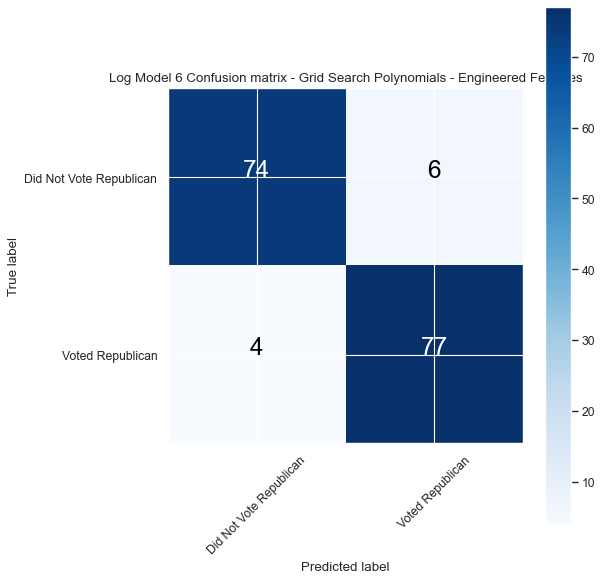

In [68]:
#View the confusion matrix
confusion_log_model_6 = metrics.confusion_matrix(y_test_log_model_6, y_pred_test_log_model_6)
plot_confusion_matrix(confusion_log_model_6, title='Log Model 6 Confusion matrix - Grid Search Polynomials - Engineered Features')

In [69]:
#Run this code to save the model data
#make_pickle(log_model_6, 'log_model_6')

## 11. KNN - Standard Set

In [70]:
#Splits the data for the KNN model gridsearch, using the standard features
X_train_KNN_model_1, X_test_KNN_model_1, y_train_KNN_model_1, y_test_KNN_model_1 =  reset_data()

sc_KNN_model_1=StandardScaler()
X_train_scaled_KNN_model_1= sc_KNN_model_1.fit_transform(X_train_KNN_model_1)
X_test_scaled_KNN_model_1 = sc_KNN_model_1.transform(X_test_KNN_model_1)

In [71]:
#Creates a pipeline of parameters for the KNN model
pipe_KNN_poly = Pipeline([('poly', PolynomialFeatures(degree=3)),
            ('scl', StandardScaler()),
            ('knn', KNeighborsClassifier())])

In [72]:
#Creates parameters for the KNN model
neighbors= list(range(1,20,2))
grid_params_KNN = [{'knn__n_neighbors':neighbors, 'knn__weights': ['uniform', 'distance']}] 

In [73]:
#Creates the KNN model
KNN_model_1 = GridSearchCV(estimator=pipe_KNN_poly, param_grid=grid_params_KNN, scoring='f1',
                           cv=5)
#I've taken out the parameter 'verbose=5' to neaten up the notebook

In [74]:
#Fits the KNN model to the data
KNN_model_1.fit(X_train_scaled_KNN_model_1, y_train_KNN_model_1)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                                       ('scl', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid=[{'knn__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17,
                                               19],
                          'knn__weights': ['uniform', 'distance']}],
             scoring='f1')

In [75]:
# Best params
print('Best params: %s' % KNN_model_1.best_params_)
# Best training data accuracy
print('Best training accuracy: %.3f' % KNN_model_1.best_score_)
# Predict on test data with best params
y_pred_test_KNN_model_1 = KNN_model_1.predict(X_test_scaled_KNN_model_1)
# Test data accuracy of model with best params
print('Test set F1 score for best params: %.4f ' % f1_score(y_test_KNN_model_1, y_pred_test_KNN_model_1))

Best params: {'knn__n_neighbors': 1, 'knn__weights': 'uniform'}
Best training accuracy: 0.870
Test set F1 score for best params: 0.9080 


In [76]:
# Make predictions for scoring purposes
y_pred_train_KNN_model_1 = KNN_model_1.predict(X_train_scaled_KNN_model_1)

# Prints the accuracy and f1 scores
print("Training Accuracy for KNN Model 1 (Standard Features):", accuracy_score(y_train_KNN_model_1, y_pred_train_KNN_model_1))
print("Training F1 Score for KNN Model 1 (Standard Features):", f1_score(y_train_KNN_model_1, y_pred_train_KNN_model_1))
print("")
print("Testing Accuracy for KNN Model 1 (Standard Features):", accuracy_score(y_test_KNN_model_1, y_pred_test_KNN_model_1))
print("Testing F1 Score for KNN Model 1 (Standard Features):", f1_score(y_test_KNN_model_1, y_pred_test_KNN_model_1))

Training Accuracy for KNN Model 1 (Standard Features): 1.0
Training F1 Score for KNN Model 1 (Standard Features): 1.0

Testing Accuracy for KNN Model 1 (Standard Features): 0.906832298136646
Testing F1 Score for KNN Model 1 (Standard Features): 0.9079754601226994


Confusion Matrix


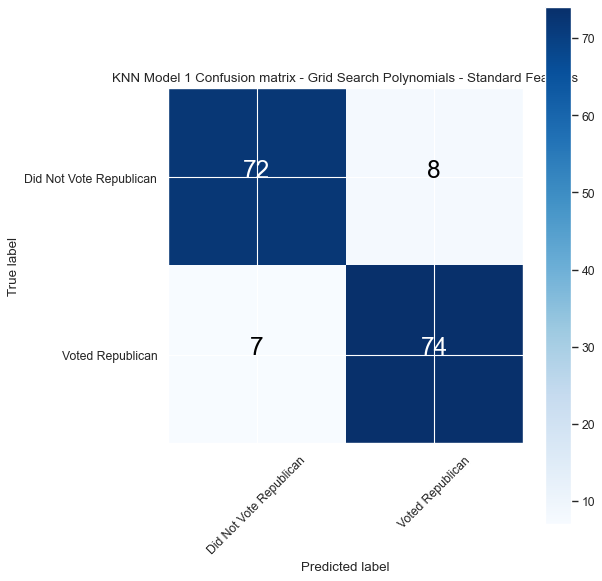

In [77]:
#Plots the confusion matrix
confusion_KNN_model_1 = metrics.confusion_matrix(y_test_KNN_model_1, y_pred_test_KNN_model_1)
plot_confusion_matrix(confusion_KNN_model_1, title='KNN Model 1 Confusion matrix - Grid Search Polynomials - Standard Features')

## 12. KNN - Engineered Features

In [78]:
#Splits the data for the KNN model gridsearch, using the engineered features
X_train_KNN_model_2, X_test_KNN_model_2, y_train_KNN_model_2, y_test_KNN_model_2 =  reset_data('engineered')

sc_KNN_model_2=StandardScaler()
X_train_scaled_KNN_model_2= sc_KNN_model_2.fit_transform(X_train_KNN_model_2)
X_test_scaled_KNN_model_2 = sc_KNN_model_2.transform(X_test_KNN_model_2)

In [79]:
#Creates the KNN model
KNN_model_2 = GridSearchCV(estimator=pipe_KNN_poly, param_grid=grid_params_KNN, scoring='f1',
                           cv=5)
#I've taken out the parameter 'verbose=5' to neaten up the notebook

In [80]:
#Fits the KNN model to the data
KNN_model_2.fit(X_train_scaled_KNN_model_2, y_train_KNN_model_2)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                                       ('scl', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid=[{'knn__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17,
                                               19],
                          'knn__weights': ['uniform', 'distance']}],
             scoring='f1')

In [81]:
# Best params
print('Best params: %s' % KNN_model_2.best_params_)
# Best training data accuracy
print('Best training accuracy: %.3f' % KNN_model_2.best_score_)
# Predict on test data with best params
y_pred_test_KNN_model_2 = KNN_model_2.predict(X_test_scaled_KNN_model_2)
# Test data accuracy of model with best params
print('Test set F1 score for best params: %.4f ' % f1_score(y_test_KNN_model_2, y_pred_test_KNN_model_2))

Best params: {'knn__n_neighbors': 17, 'knn__weights': 'uniform'}
Best training accuracy: 0.854
Test set F1 score for best params: 0.7974 


In [82]:
# Make predictions for scoring purposes
y_pred_train_KNN_model_2 = KNN_model_2.predict(X_train_scaled_KNN_model_2)

# Prints the accuracy and f1 scores
print("Training Accuracy for KNN Model 2 (Engineered Features):", accuracy_score(y_train_KNN_model_2, y_pred_train_KNN_model_2))
print("Training F1 Score for KNN Model 2 (Engineered Features):", f1_score(y_train_KNN_model_2, y_pred_train_KNN_model_2))
print("")
print("Testing Accuracy for KNN Model 2 (Engineered Features):", accuracy_score(y_test_KNN_model_2, y_pred_test_KNN_model_2))
print("Testing F1 Score for KNN Model 2 (Engineered Features):", f1_score(y_test_KNN_model_2, y_pred_test_KNN_model_2))

Training Accuracy for KNN Model 2 (Engineered Features): 0.8926905132192846
Training F1 Score for KNN Model 2 (Engineered Features): 0.8920187793427231

Testing Accuracy for KNN Model 2 (Engineered Features): 0.8074534161490683
Testing F1 Score for KNN Model 2 (Engineered Features): 0.7973856209150327


Confusion Matrix


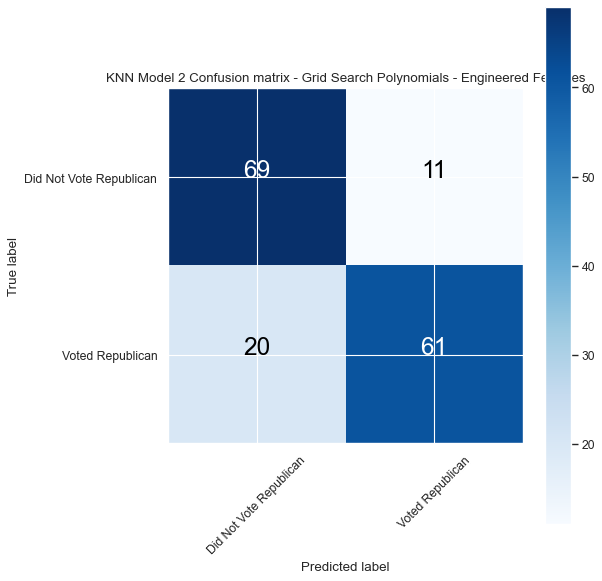

In [83]:
#Plots the confusin matrix
confusion_KNN_model_2 = metrics.confusion_matrix(y_test_KNN_model_2, y_pred_test_KNN_model_2)
plot_confusion_matrix(confusion_KNN_model_2, title='KNN Model 2 Confusion matrix - Grid Search Polynomials - Engineered Features')

## 13. A Function to Visualize Decision Trees

In [84]:
def plot_decision_tree(clf, feature_cols, class_titles, file_name):
    dot_data = StringIO()
    export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols, class_names = class_titles)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    
    
    graph.write_png(file_name + '.png')
    
    return Image(graph.create_png())

## 14. Decision Trees - Standard Set

In [85]:
#Splits the data for the decision tree model using the standard features
X_train_DT_model_1, X_test_DT_model_1, y_train_DT_model_1, y_test_DT_model_1 =  reset_data()

sc_DT_model_1=StandardScaler()
X_train_scaled_DT_model_1= sc_DT_model_1.fit_transform(X_train_DT_model_1)
X_test_scaled_DT_model_1 = sc_DT_model_1.transform(X_test_DT_model_1)

In [86]:
# Create Decision Tree classifer object
DT_model_1 = DecisionTreeClassifier()
# Train Decision Tree Classifer
DT_model_1 = DT_model_1.fit(X_train_scaled_DT_model_1, y_train_DT_model_1)

In [87]:
# Predict on training data with best params
y_pred_train_DT_model_1 = DT_model_1.predict(X_train_scaled_DT_model_1)

#Predict the response for test dataset
y_pred_test_DT_model_1 = DT_model_1.predict(X_test_scaled_DT_model_1)

# Prints the accuracy and f1 scores
print("Training Accuracy for Decision Tree Model 1 (Standard Features):", accuracy_score(y_train_DT_model_1, y_pred_train_DT_model_1))
print("Training F1 Score for Decision Tree Model 1 (Standard Features):", f1_score(y_train_DT_model_1, y_pred_train_DT_model_1))
print("")
print("Testing Accuracy for Decision Tree Model 1 (Standard Features):", accuracy_score(y_test_DT_model_1, y_pred_test_DT_model_1))
print("Testing F1 Score for Decision Tree Model 1 (Standard Features):", f1_score(y_test_DT_model_1, y_pred_test_DT_model_1))

Training Accuracy for Decision Tree Model 1 (Standard Features): 1.0
Training F1 Score for Decision Tree Model 1 (Standard Features): 1.0

Testing Accuracy for Decision Tree Model 1 (Standard Features): 0.9316770186335404
Testing F1 Score for Decision Tree Model 1 (Standard Features): 0.9290322580645162


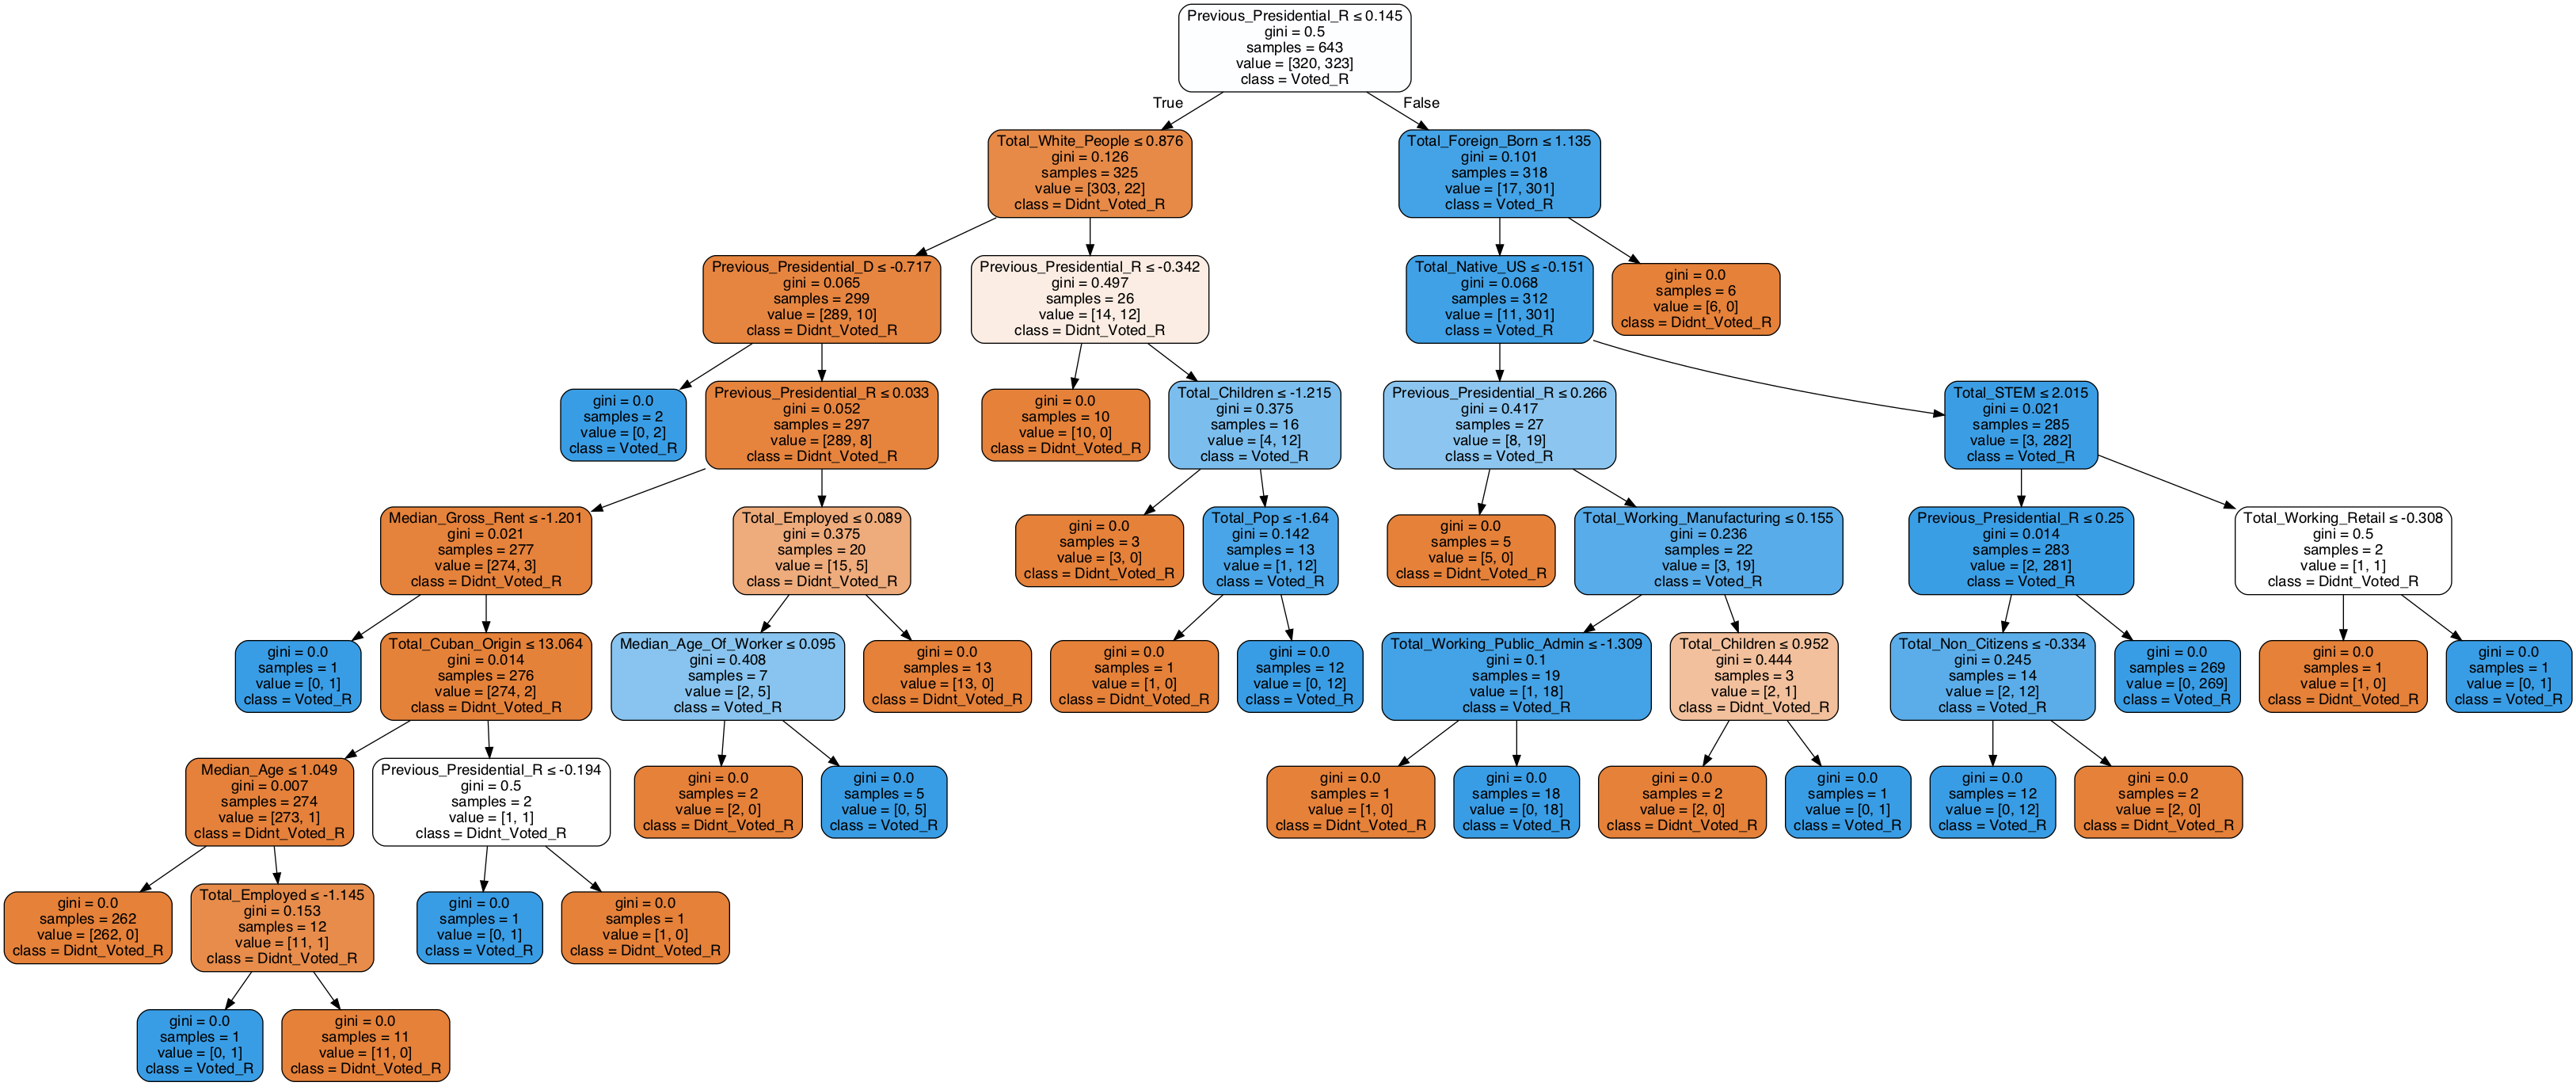

In [88]:
plot_decision_tree(DT_model_1, list(X_train_DT_model_1.columns), ['Didnt_Voted_R', 'Voted_R'], 'DT_model_1')

## 14. Decision Trees - Engineered Set


In [89]:
#Splits the data for the decision tree model using the engineered features
X_train_DT_model_2, X_test_DT_model_2, y_train_DT_model_2, y_test_DT_model_2 =  reset_data('engineered')

sc_DT_model_2=StandardScaler()
X_train_scaled_DT_model_2= sc_DT_model_2.fit_transform(X_train_DT_model_2)
X_test_scaled_DT_model_2 = sc_DT_model_2.transform(X_test_DT_model_2)

In [90]:
# Create Decision Tree classifer object
DT_model_2 = DecisionTreeClassifier()
# Train Decision Tree Classifer
DT_model_2 = DT_model_2.fit(X_train_scaled_DT_model_2, y_train_DT_model_2)

In [91]:
# Predict on training data with best params
y_pred_train_DT_model_2 = DT_model_2.predict(X_train_scaled_DT_model_2)

#Predict the response for test dataset
y_pred_test_DT_model_2 = DT_model_2.predict(X_test_scaled_DT_model_2)

# Prints the accuracy and f1 scores
print("Training Accuracy for Decision Tree Model 2 (Engineered Features):", accuracy_score(y_train_DT_model_2, y_pred_train_DT_model_2))
print("Training F1 Score for Decision Tree Model 2 (Engineered Features):", f1_score(y_train_DT_model_2, y_pred_train_DT_model_2))
print("")
print("Testing Accuracy for Decision Tree Model 2 (Engineered Features):", accuracy_score(y_test_DT_model_2, y_pred_test_DT_model_2))
print("Testing F1 Score for Decision Tree Model 2 (Engineered Features):", f1_score(y_test_DT_model_2, y_pred_test_DT_model_2))

Training Accuracy for Decision Tree Model 2 (Engineered Features): 1.0
Training F1 Score for Decision Tree Model 2 (Engineered Features): 1.0

Testing Accuracy for Decision Tree Model 2 (Engineered Features): 0.9192546583850931
Testing F1 Score for Decision Tree Model 2 (Engineered Features): 0.9171974522292994


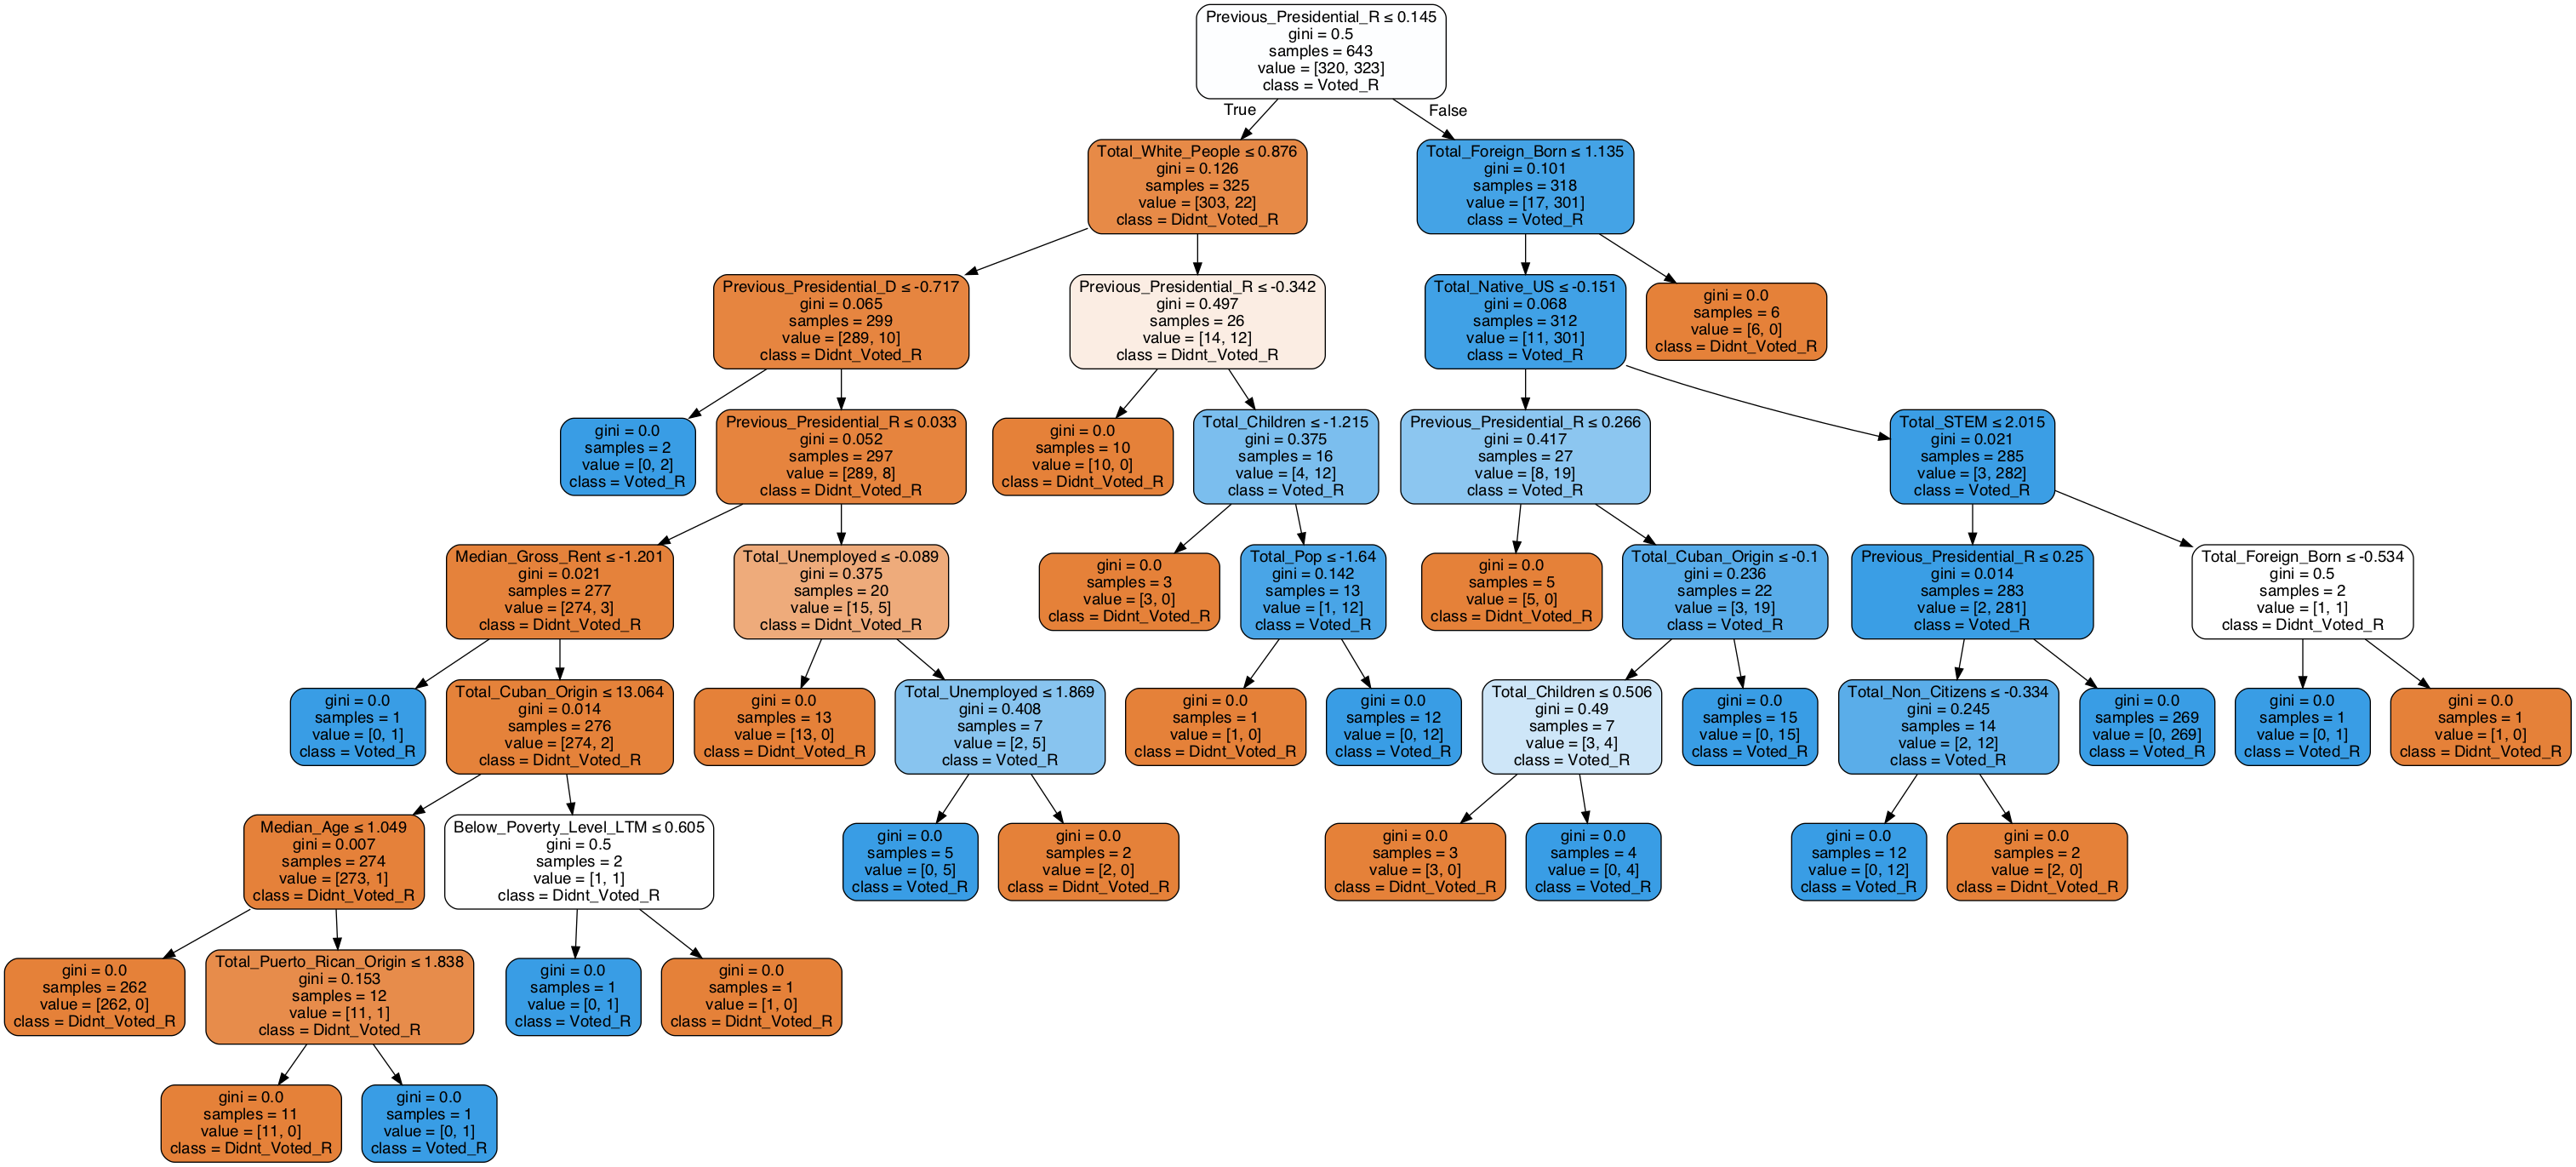

In [92]:
plot_decision_tree(DT_model_2, list(X_train_DT_model_2.columns), ['Didnt_Voted_R', 'Voted_R'], 'DT_model_2')

## 15. Decision Trees - Grid Search - Standard Set

In [93]:
#Splits the data for the decision tree model gridsearch, using the standard features
X_train_DT_model_3, X_test_DT_model_3, y_train_DT_model_3, y_test_DT_model_3 =  reset_data()

sc_DT_model_3=StandardScaler()
X_train_scaled_DT_model_3= sc_DT_model_3.fit_transform(X_train_DT_model_3)
X_test_scaled_DT_model_3 = sc_DT_model_3.transform(X_test_DT_model_3)

In [94]:
# The scorers used in the gridsearch to find the best parameters
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

In [95]:
#Parameters and model creation
parameters ={'criterion': ['gini','entropy'], 'min_samples_leaf' : range(5,100,15), 'max_depth': range(2,20,1)}

DT_model_3 = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid= parameters,
                  scoring=scoring, cv=5, refit='AUC', return_train_score=True)
#I've taken out the parameter 'verbose=5' to neaten up the notebook


In [96]:
DT_model_3.fit(X_train_scaled_DT_model_3, y_train_DT_model_3)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(2, 20),
                         'min_samples_leaf': range(5, 100, 15)},
             refit='AUC', return_train_score=True,
             scoring={'AUC': 'roc_auc',
                      'Accuracy': make_scorer(accuracy_score)})

In [97]:
# Predict on training data with best params
y_pred_train_DT_model_3 = DT_model_3.predict(X_train_scaled_DT_model_3)

#Predict the response for test dataset
y_pred_test_DT_model_3 = DT_model_3.predict(X_test_scaled_DT_model_3)

# Prints the accuracy and f1 scores
print("Training Accuracy for Decision Tree Model 3 GS (Standard Features):", accuracy_score(y_train_DT_model_3, y_pred_train_DT_model_3))
print("Training F1 Score for Decision Tree Model 3 GS (Standard Features):", f1_score(y_train_DT_model_3, y_pred_train_DT_model_3))
print("")
print("Testing Accuracy for Decision Tree Model 3 GS (Standard Features):", accuracy_score(y_test_DT_model_3, y_pred_test_DT_model_3))
print("Testing F1 Score for Decision Tree Model 3 GS (Standard Features):", f1_score(y_test_DT_model_3, y_pred_test_DT_model_3))

Training Accuracy for Decision Tree Model 3 GS (Standard Features): 0.9393468118195957
Training F1 Score for Decision Tree Model 3 GS (Standard Features): 0.9391575663026521

Testing Accuracy for Decision Tree Model 3 GS (Standard Features): 0.9627329192546584
Testing F1 Score for Decision Tree Model 3 GS (Standard Features): 0.9620253164556961


In [98]:
print('The top score for a decision tree is: ' + str(DT_model_3.best_score_))
print('The parameters for the top performing decision tree is: ' + str(DT_model_3.best_params_))
print('The top performing decision tree is: ')
print(DT_model_3.best_estimator_)

The top score for a decision tree is: 0.9787721604567308
The parameters for the top performing decision tree is: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 35}
The top performing decision tree is: 
DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=35,
                       random_state=42)


In [99]:
DT_model_3.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_criterion', 'param_max_depth', 'param_min_samples_leaf', 'params', 'split0_test_AUC', 'split1_test_AUC', 'split2_test_AUC', 'split3_test_AUC', 'split4_test_AUC', 'mean_test_AUC', 'std_test_AUC', 'rank_test_AUC', 'split0_train_AUC', 'split1_train_AUC', 'split2_train_AUC', 'split3_train_AUC', 'split4_train_AUC', 'mean_train_AUC', 'std_train_AUC', 'split0_test_Accuracy', 'split1_test_Accuracy', 'split2_test_Accuracy', 'split3_test_Accuracy', 'split4_test_Accuracy', 'mean_test_Accuracy', 'std_test_Accuracy', 'rank_test_Accuracy', 'split0_train_Accuracy', 'split1_train_Accuracy', 'split2_train_Accuracy', 'split3_train_Accuracy', 'split4_train_Accuracy', 'mean_train_Accuracy', 'std_train_Accuracy'])

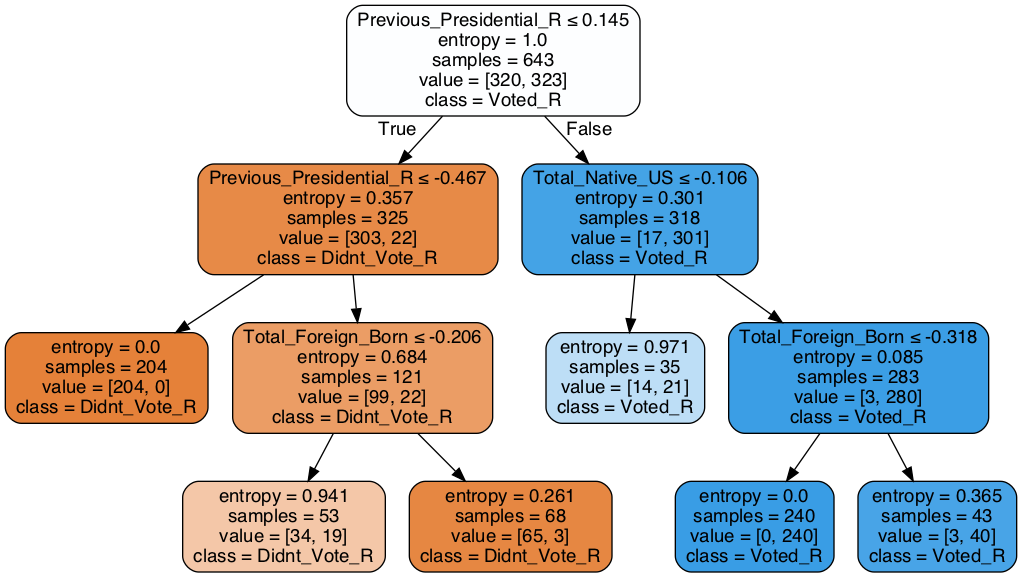

In [100]:
plot_decision_tree(DT_model_3.best_estimator_, list(X_train_DT_model_3.columns), ['Didnt_Vote_R', 'Voted_R'], 'DT_model_3')

## 16. Decision Trees - Grid Search - Engineered Set

In [101]:
#Splits the data for the decision tree model gridsearch, using the engineered features
X_train_DT_model_4, X_test_DT_model_4, y_train_DT_model_4, y_test_DT_model_4 =  reset_data('engineered')

sc_DT_model_4=StandardScaler()
X_train_scaled_DT_model_4= sc_DT_model_4.fit_transform(X_train_DT_model_4)
X_test_scaled_DT_model_4 = sc_DT_model_4.transform(X_test_DT_model_4)

In [102]:
#Parameters and model creation
parameters ={'criterion': ['gini','entropy'], 'min_samples_leaf' : range(5,100,15), 'max_depth': range(2,20,1)}

DT_model_4 = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid= parameters,
                  scoring=scoring, cv=5, refit='AUC', return_train_score=True)
#I've taken out the parameter 'verbose=5' to neaten up the notebook

In [103]:
DT_model_4.fit(X_train_scaled_DT_model_4, y_train_DT_model_4)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(2, 20),
                         'min_samples_leaf': range(5, 100, 15)},
             refit='AUC', return_train_score=True,
             scoring={'AUC': 'roc_auc',
                      'Accuracy': make_scorer(accuracy_score)})

In [104]:
# Predict on training data with best params
y_pred_train_DT_model_4 = DT_model_4.predict(X_train_scaled_DT_model_4)

#Predict the response for test dataset
y_pred_test_DT_model_4 = DT_model_4.predict(X_test_scaled_DT_model_4)

# Prints the accuracy and f1 scores
print("Training Accuracy for Decision Tree Model 4 GS (Engineered Features):", accuracy_score(y_train_DT_model_4, y_pred_train_DT_model_4))
print("Training F1 Score for Decision Tree Model 4 GS (Engineered Features):", f1_score(y_train_DT_model_4, y_pred_train_DT_model_4))
print("")
print("Testing Accuracy for Decision Tree Model 4 GS (Engineered Features):", accuracy_score(y_test_DT_model_4, y_pred_test_DT_model_4))
print("Testing F1 Score for Decision Tree Model 4 GS (Engineered Features):", f1_score(y_test_DT_model_4, y_pred_test_DT_model_4))

Training Accuracy for Decision Tree Model 4 GS (Engineered Features): 0.9393468118195957
Training F1 Score for Decision Tree Model 4 GS (Engineered Features): 0.9391575663026521

Testing Accuracy for Decision Tree Model 4 GS (Engineered Features): 0.9627329192546584
Testing F1 Score for Decision Tree Model 4 GS (Engineered Features): 0.9620253164556961


In [105]:
print('The top score for a decision tree is: ' + str(DT_model_4.best_score_))
print('The parameters for the top performing decision tree is: ' + str(DT_model_4.best_params_))
print('The top performing decision tree is: ')
print(DT_model_4.best_estimator_)

The top score for a decision tree is: 0.9779176682692308
The parameters for the top performing decision tree is: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 35}
The top performing decision tree is: 
DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=35,
                       random_state=42)


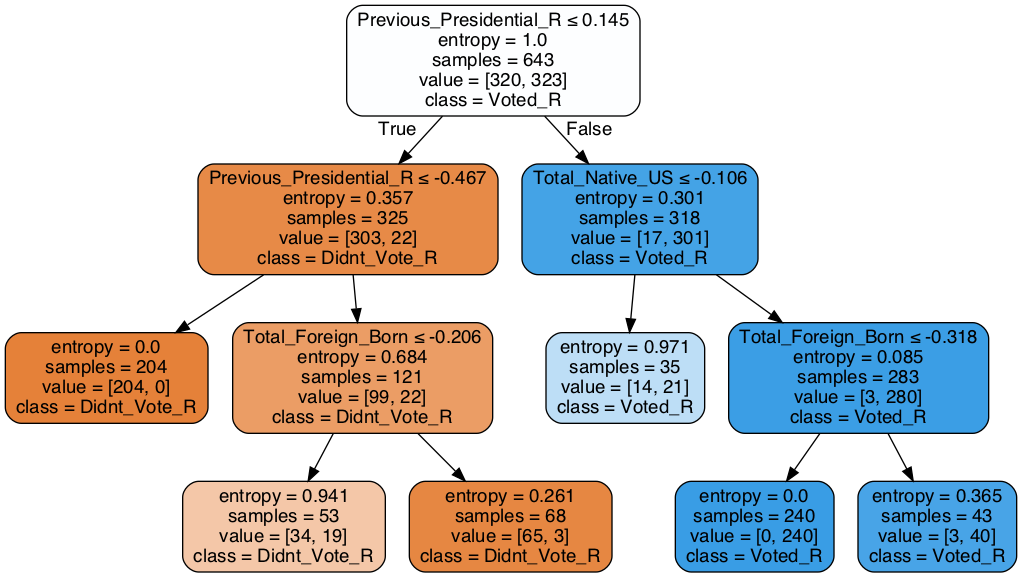

In [106]:
plot_decision_tree(DT_model_4.best_estimator_, list(X_train_DT_model_4.columns), ['Didnt_Vote_R', 'Voted_R'], 'DT_model_4')

## 17. Random Forest - Standard Set

In [107]:
#Creates the parameters for the random forest model
param_grid = { 
    'n_estimators': [200,300,400],
    'max_features': [0.25, 0.33, 0.5 ],
    'max_depth' : [5,6,7,8,9],
    'min_samples_leaf': [0.03,0.04,0.05,0.06]
}

In [108]:
#Splits the data for the random forest model using the standard features
X_train_rfc_model_1, X_test_rfc_model_1, y_train_rfc_model_1, y_test_rfc_model_1 =  reset_data()

sc_rfc_model_1=StandardScaler()
X_train_scaled_rfc_model_1= sc_rfc_model_1.fit_transform(X_train_rfc_model_1)
X_test_scaled_rfc_model_1 = sc_rfc_model_1.transform(X_test_rfc_model_1)

In [109]:
#Fits the rf model
rfc_model_1 = GridSearchCV(estimator= RandomForestClassifier(random_state = 23), param_grid=param_grid, cv= 5, n_jobs=-1)
#I've taken out the parameter 'verbose=5' to neaten up the notebook
rfc_model_1.fit(X_train_scaled_rfc_model_1, y_train_rfc_model_1)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=23), n_jobs=-1,
             param_grid={'max_depth': [5, 6, 7, 8, 9],
                         'max_features': [0.25, 0.33, 0.5],
                         'min_samples_leaf': [0.03, 0.04, 0.05, 0.06],
                         'n_estimators': [200, 300, 400]})

In [110]:
#Loading the saved random forest model with pickle
#rfc_model_1_pkl = open('./Classification_Models_After_rfc_model_1.pkl', 'rb')
#rfc_model_1 = pickle.load(rfc_model_1_pkl)
#print("Loaded rfc_model_1 Pickle :: ", rfc_model_1)
#print(rfc_model_1.best_estimator_.get_params())

In [111]:
# Predict on training data with best params
pred_rfc_model_1_train = rfc_model_1.predict(X_train_scaled_rfc_model_1)
#Predict the response for test dataset
pred_rfc_model_1 = rfc_model_1.predict(X_test_scaled_rfc_model_1)

In [112]:
# Prints the accuracy and f1 scores
print("Training Accuracy for Random Forest Model 1 (Standard Features):", accuracy_score(y_train_rfc_model_1, pred_rfc_model_1_train))
print("Training F1 Score for Random Forest Model 1 (Standard Features):", f1_score(y_train_rfc_model_1, pred_rfc_model_1_train))
print("")
print("Testing Accuracy for Random Forest Model 1 (Standard Features):", accuracy_score(y_test_rfc_model_1, pred_rfc_model_1))
print("Testing F1 Score for Random Forest Model 1 (Standard Features):", f1_score(y_test_rfc_model_1, pred_rfc_model_1))

Training Accuracy for Random Forest Model 1 (Standard Features): 0.9548989113530326
Training F1 Score for Random Forest Model 1 (Standard Features): 0.9550387596899225

Testing Accuracy for Random Forest Model 1 (Standard Features): 0.9503105590062112
Testing F1 Score for Random Forest Model 1 (Standard Features): 0.949367088607595


In [113]:
print('The top score for a random forest is: ' + str(rfc_model_1.best_score_))
print('The parameters for the top performing random forest is: ' + str(rfc_model_1.best_params_))
print('The top performing random forest is: ')
print(rfc_model_1.best_estimator_)

The top score for a random forest is: 0.9486555232558139
The parameters for the top performing random forest is: {'max_depth': 5, 'max_features': 0.25, 'min_samples_leaf': 0.03, 'n_estimators': 200}
The top performing random forest is: 
RandomForestClassifier(max_depth=5, max_features=0.25, min_samples_leaf=0.03,
                       n_estimators=200, random_state=23)


In [114]:
#Run this code to save the random forest model data
#make_pickle(rfc_model_1, 'rfc_model_1')

## 18. Random Forest - Engineered Set

In [115]:
#Splits the data for the random forest model using the engineered features
X_train_rfc_model_2, X_test_rfc_model_2, y_train_rfc_model_2, y_test_rfc_model_2 =  reset_data('engineered')

sc_rfc_model_2=StandardScaler()
X_train_scaled_rfc_model_2= sc_rfc_model_2.fit_transform(X_train_rfc_model_2)
X_test_scaled_rfc_model_2 = sc_rfc_model_2.transform(X_test_rfc_model_2)

In [116]:
#Fits the rf model
rfc_model_2 = GridSearchCV(estimator= RandomForestClassifier(random_state = 23), param_grid=param_grid, cv= 5, n_jobs=-1)
#I've taken out the parameter 'verbose=5' to neaten up the notebook
rfc_model_2.fit(X_train_scaled_rfc_model_2, y_train_rfc_model_2)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=23), n_jobs=-1,
             param_grid={'max_depth': [5, 6, 7, 8, 9],
                         'max_features': [0.25, 0.33, 0.5],
                         'min_samples_leaf': [0.03, 0.04, 0.05, 0.06],
                         'n_estimators': [200, 300, 400]})

In [117]:
#Loading the saved random forest smote model with pickle
#rfc_model_2_pkl = open('./Classification_Models_After_rfc_model_2.pkl', 'rb')
#rfc_model_2 = pickle.load(rfc_model_2_pkl)
#print("Loaded rfc_model_2 Pickle :: ", rfc_model_2)
#print(rfc_model_2.best_estimator_.get_params())

In [118]:
# Predict on training data with best params
pred_rfc_model_2_train = rfc_model_2.predict(X_train_scaled_rfc_model_2)
#Predict the response for test dataset
pred_rfc_model_2 = rfc_model_2.predict(X_test_scaled_rfc_model_2)

In [119]:
# Prints the accuracy and f1 scores
print("Training Accuracy for Random Forest Model 2 (Engineered Features):", accuracy_score(y_train_rfc_model_2, pred_rfc_model_2_train))
print("Training F1 Score for Random Forest Model 2 (Engineered Features):", f1_score(y_train_rfc_model_2, pred_rfc_model_2_train))
print("")
print("Testing Accuracy for Random Forest Model 2 (Engineered Features):", accuracy_score(y_test_rfc_model_2, pred_rfc_model_2))
print("Testing F1 Score for Random Forest Model 2 (Engineered Features):", f1_score(y_test_rfc_model_2, pred_rfc_model_2))

Training Accuracy for Random Forest Model 2 (Engineered Features): 0.9564541213063764
Training F1 Score for Random Forest Model 2 (Engineered Features): 0.9566563467492261

Testing Accuracy for Random Forest Model 2 (Engineered Features): 0.9503105590062112
Testing F1 Score for Random Forest Model 2 (Engineered Features): 0.949367088607595


In [120]:
print('The top score for a random forest is: ' + str(rfc_model_2.best_score_))
print('The parameters for the top performing random forest is: ' + str(rfc_model_2.best_params_))
print('The top performing random forest is: ')
print(rfc_model_2.best_estimator_)

The top score for a random forest is: 0.9486555232558139
The parameters for the top performing random forest is: {'max_depth': 5, 'max_features': 0.25, 'min_samples_leaf': 0.03, 'n_estimators': 200}
The top performing random forest is: 
RandomForestClassifier(max_depth=5, max_features=0.25, min_samples_leaf=0.03,
                       n_estimators=200, random_state=23)


In [121]:
#Run this code to save the random forest model data
#make_pickle(rfc_model_2, 'rfc_model_2')

## 19. XGBoost - Standard Set

In [122]:
X_train_xgb_model_1, X_test_xgb_model_1, y_train_xgb_model_1, y_test_xgb_model_1 =  reset_data()

sc_xgb_model_1 = StandardScaler()
X_train_scaled_xgb_model_1= sc_xgb_model_1.fit_transform(X_train_xgb_model_1)
X_test_scaled_xgb_model_1 = sc_xgb_model_1.transform(X_test_xgb_model_1)

In [123]:
#fits and then scores the XGBoost model
xgb_model_1 = xgb.XGBClassifier()
xgb_model_1.fit(X_train_scaled_xgb_model_1, y_train_xgb_model_1)

training_preds_xgb_model_1 = xgb_model_1.predict(X_train_scaled_xgb_model_1)
val_preds_xgb_model_1 = xgb_model_1.predict(X_test_scaled_xgb_model_1)

training_accuracy_xgb_model_1 = accuracy_score(y_train_xgb_model_1, training_preds_xgb_model_1)
val_accuracy_xgb_model_1 = accuracy_score(y_test_xgb_model_1, val_preds_xgb_model_1)

print("Training Accuracy for the standard model: {:.4}%".format(training_accuracy_xgb_model_1 * 100))
print("Validation Accuracy for the standard model: {:.4}%".format(val_accuracy_xgb_model_1 * 100))

[23:14:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy for the standard model: 100.0%
Validation Accuracy for the standard model: 96.27%


In [124]:
#Creates a parameter grid for the gridsearch of XGBoost
param_grid = {
    "learning_rate": [0.1],
    'max_depth': [6],
    'min_child_weight': [10],
    'subsample': [ 0.7],
    'n_estimators': [5, 30, 100, 250],
}

In [125]:
#Creates an XGBoost model
xgb_model_1 = xgb.XGBClassifier()

In [126]:
#Fits the data to the model
xgb_model_1 = GridSearchCV(xgb_model_1, param_grid, scoring='accuracy', cv=None, n_jobs=1)
#I've taken out the parameter 'verbose=5' to neaten up the notebook
xgb_model_1.fit(X_train_scaled_xgb_model_1, y_train_xgb_model_1)

[23:14:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:14:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:14:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:14:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameter

In [127]:
#Prints the best parameters from the XGBoost model
best_parameters_xgb_model_1 = xgb_model_1.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters_xgb_model_1.keys()):
    print("%s: %r" % (param_name, best_parameters_xgb_model_1[param_name]))

training_preds_xgb_model_1 = xgb_model_1.predict(X_train_scaled_xgb_model_1)
val_preds_xgb_model_1 = xgb_model_1.predict(X_test_scaled_xgb_model_1)
training_accuracy_xgb_model_1 = accuracy_score(y_train_xgb_model_1, training_preds_xgb_model_1)
val_accuracy_xgb_model_1 = accuracy_score(y_test_xgb_model_1, val_preds_xgb_model_1)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy_xgb_model_1 * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy_xgb_model_1 * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 6
min_child_weight: 10
n_estimators: 100
subsample: 0.7

Training Accuracy: 96.73%
Validation accuracy: 96.89%


In [128]:
#Makes predictions for model scoring
y_pred_train_xgb_model_1 = xgb_model_1.predict(X_train_scaled_xgb_model_1)
y_pred_test_xgb_model_1 = xgb_model_1.predict(X_test_scaled_xgb_model_1)

# Prints the accuracy and f1 scores
print('Training Accuracy for XGBoost Model 1 (Standard Features): %.4f ' % accuracy_score(y_train_xgb_model_1, y_pred_train_xgb_model_1))
print('Training F1 Score for XGBoost Model 1 (Standard Features): %.4f ' % f1_score(y_train_xgb_model_1, y_pred_train_xgb_model_1))
print('')
print('Testing Accuracy for XGBoost Model 1 (Standard Features): %.4f ' % accuracy_score(y_test_xgb_model_1, y_pred_test_xgb_model_1))
print('Testing F1 Score for XGBoost Model 1 (Standard Features): %.4f ' % f1_score(y_test_xgb_model_1, y_pred_test_xgb_model_1))

Training Accuracy for XGBoost Model 1 (Standard Features): 0.9673 
Training F1 Score for XGBoost Model 1 (Standard Features): 0.9673 

Testing Accuracy for XGBoost Model 1 (Standard Features): 0.9689 
Testing F1 Score for XGBoost Model 1 (Standard Features): 0.9689 


## 20. XGBoost - Engineered Set

In [129]:
X_train_xgb_model_2, X_test_xgb_model_2, y_train_xgb_model_2, y_test_xgb_model_2 =  reset_data('engineered')

sc_xgb_model_2 = StandardScaler()
X_train_scaled_xgb_model_2= sc_xgb_model_2.fit_transform(X_train_xgb_model_2)
X_test_scaled_xgb_model_2 = sc_xgb_model_2.transform(X_test_xgb_model_2)

In [130]:
#fits and then scores the XGBoost model
xgb_model_2 = xgb.XGBClassifier()
xgb_model_2.fit(X_train_scaled_xgb_model_2, y_train_xgb_model_2)

training_preds_xgb_model_2 = xgb_model_2.predict(X_train_scaled_xgb_model_2)
val_preds_xgb_model_2 = xgb_model_2.predict(X_test_scaled_xgb_model_2)

training_accuracy_xgb_model_2 = accuracy_score(y_train_xgb_model_2, training_preds_xgb_model_2)
val_accuracy_xgb_model_2 = accuracy_score(y_test_xgb_model_2, val_preds_xgb_model_2)

print("Training Accuracy for the standard model: {:.4}%".format(training_accuracy_xgb_model_2 * 100))
print("Validation Accuracy for the standard model: {:.4}%".format(val_accuracy_xgb_model_2 * 100))

[23:14:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy for the standard model: 100.0%
Validation Accuracy for the standard model: 95.03%


In [131]:
#Creates an XGBoost model
xgb_model_2 = xgb.XGBClassifier()

In [132]:
#Fits the data to the model
xgb_model_2 = GridSearchCV(xgb_model_2, param_grid, scoring='accuracy', cv=None, n_jobs=1)
#I've taken out the parameter 'verbose=5' to neaten up the notebook
xgb_model_2.fit(X_train_scaled_xgb_model_2, y_train_xgb_model_2)

[23:14:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:14:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:14:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:14:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameter

In [133]:
#Prints the best parameters from the XGBoost model
best_parameters_xgb_model_2 = xgb_model_2.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters_xgb_model_2.keys()):
    print("%s: %r" % (param_name, best_parameters_xgb_model_2[param_name]))

training_preds_xgb_model_2 = xgb_model_2.predict(X_train_scaled_xgb_model_2)
val_preds_xgb_model_2 = xgb_model_2.predict(X_test_scaled_xgb_model_2)
training_accuracy_xgb_model_2 = accuracy_score(y_train_xgb_model_2, training_preds_xgb_model_2)
val_accuracy_xgb_model_2 = accuracy_score(y_test_xgb_model_2, val_preds_xgb_model_2)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy_xgb_model_2 * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy_xgb_model_2 * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 6
min_child_weight: 10
n_estimators: 250
subsample: 0.7

Training Accuracy: 96.89%
Validation accuracy: 96.27%


In [134]:
#Makes predictions for model scoring
y_pred_train_xgb_model_2 = xgb_model_2.predict(X_train_scaled_xgb_model_2)
y_pred_test_xgb_model_2 = xgb_model_2.predict(X_test_scaled_xgb_model_2)

# Prints the accuracy and f1 scores
print('Training Accuracy for XGBoost Model 2 (Standard Features): %.4f ' % accuracy_score(y_train_xgb_model_2, y_pred_train_xgb_model_2))
print('Training F1 Score for XGBoost Model 2 (Standard Features): %.4f ' % f1_score(y_train_xgb_model_2, y_pred_train_xgb_model_2))
print('')
print('Testing Accuracy for XGBoost Model 2 (Standard Features): %.4f ' % accuracy_score(y_test_xgb_model_2, y_pred_test_xgb_model_2))
print('Testing F1 Score for XGBoost Model 2 (Standard Features): %.4f ' % f1_score(y_test_xgb_model_2, y_pred_test_xgb_model_2))

Training Accuracy for XGBoost Model 2 (Standard Features): 0.9689 
Training F1 Score for XGBoost Model 2 (Standard Features): 0.9690 

Testing Accuracy for XGBoost Model 2 (Standard Features): 0.9627 
Testing F1 Score for XGBoost Model 2 (Standard Features): 0.9625 
